# Setup and install for SVHN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install progressbar

In [ ]:
%pip install gpflow
%pip install plotnine

In [ ]:
from plotnine import *
from plotnine.themes import *

In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [ ]:
paper_name = "gpSVHN"

In [ ]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")


This will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

[Here](https://github.com/aditya9211/SVHN-CNN/blob/master/svhn_model.ipynb) is a github project that uses the same data.



In [ ]:
data_location = '/content/drive/MyDrive/mlpapers/GP_Collab_SVHN'

In [ ]:
# Run this cell to load the dataset
train = loadmat(f'{data_location}/train_32x32.mat')
test = loadmat(f'{data_location}/test_32x32.mat')
extra = loadmat(f'{data_location}/extra_32x32.mat')

In [ ]:
# we have  png files with house numbers for the extra as well, in case of other ideas
# https://stackoverflow.com/questions/15612373/convert-image-png-to-matrix-and-then-to-1d-array


In [ ]:
# Set up the imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise, AveragePooling2D
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU, Add
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [ ]:
print(np.unique(test['y'][:12000])) # just checking that there is no order to the test data
print(train['X'].shape)
print(test['X'].shape)
print(extra['X'].shape)
print(extra['y'].shape)

[ 1  2  3  4  5  6  7  8  9 10]
(32, 32, 3, 73257)
(32, 32, 3, 26032)
(32, 32, 3, 531131)
(531131, 1)


## Inspect and Preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* turn test into validation and slice some extra for test
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.
# Why greyscale?
* So we get worse performance and have less discriminating features, allowing us to discern the impact of the GP on the features in _collaborative_ learning better.


In [ ]:
train_data = train['X']
validation_data = test['X']
test_data = extra['X'][:,:,:,:30000]
train_targets = train['y']
validation_targets = test['y']
test_targets = extra['y'][:30000]

In [ ]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
            
        ax.imshow(images[:,:,:,i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images(train_data[:,:,:,idxs],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[671, 3197, 4500, 5658, 24350, 28420, 47072, 47779, 57606, 66059]


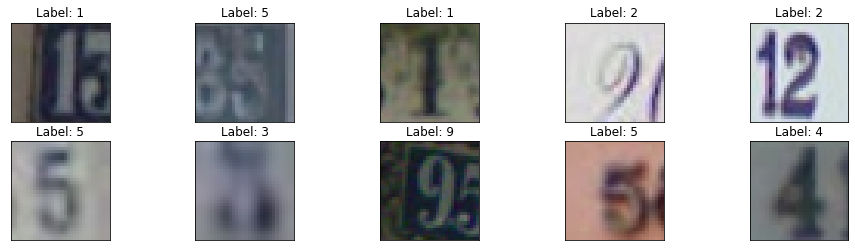

In [ ]:
plot_sample(10)

Convert the train, test and validation data to greyscale

In [ ]:
train_data_grey = train_data.mean(axis=2)
train_data_grey = np.expand_dims(train_data_grey,axis=2)
train_data_grey = np.moveaxis(train_data_grey, 3, 0)

test_data_grey = test_data.mean(axis=2)
test_data_grey = np.expand_dims(test_data_grey,axis=2)
test_data_grey = np.moveaxis(test_data_grey, 3, 0)

validation_data_grey = validation_data.mean(axis=2)
validation_data_grey = np.expand_dims(validation_data_grey,axis=2)
validation_data_grey = np.moveaxis(validation_data_grey, 3, 0)

print(train_data.shape)
print(train_data_grey.shape)

(32, 32, 3, 73257)
(73257, 32, 32, 1)


Set the 10th class to zero (represents '0' digit)

In [ ]:
train_targets[train_targets == 10] = 0
validation_targets[validation_targets == 10] = 0
test_targets[test_targets == 10] = 0

In [ ]:
def plot_images_grey(images, nrows, ncols, cls_true):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
        ax.imshow(images[i,:,:,0],cmap='gray', vmin=0, vmax=255)
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample_grey(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images_grey(train_data_grey[idxs,:,:,:],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[7038, 31426, 31989, 36730, 38065, 41154, 46719, 57394, 66873, 69878]


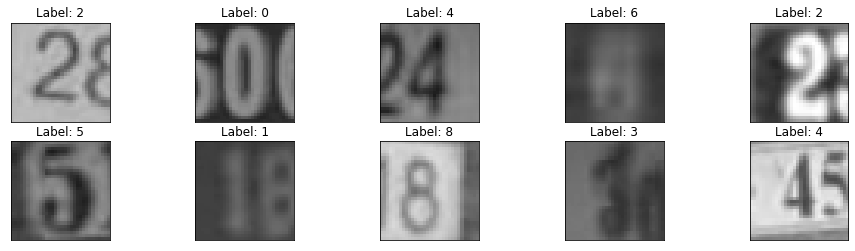

In [ ]:
plot_sample_grey(10)

In [ ]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


Let us do a dumb sequential and see how far this can go  => 78% validation is the best.. + 85% test ?!

In [ ]:
# # let's do a dumb sequential and see how far this can go  => 78% validation is the best.. + 85% test ?!

def get_model_seq(input_shape):
    model = Sequential([
                Flatten(name='F1',input_shape=input_shape),
                Dense(128, activation='relu', 
                      name = 'D1'),
                Dense(128, activation='relu', name = 'D2'),
                Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D4R'),                
                Dense(10,  activation='softmax', name = 'SFTMX1')
    ])    
    return model

model_seq = get_model_seq(train_data_grey[0,:,:,:].shape)

# model_seq.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# callbacks_seq = [ EarlyStopping(monitor='val_sparse_categorical_accuracy',
#                            mode='max',
#                            patience=60)
#                 ]

# history_seq = model_seq.fit(  train_data_grey, 
#                       train_targets,
#                       epochs=500, 
#                       validation_data=(validation_data_grey, validation_targets),
#                       callbacks=callbacks_seq,
#                       batch_size=512)

# plot_history(history_seq)
# model_seq.evaluate(test_data_grey,test_targets)

model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 F1 (Flatten)                (None, 1024)              0         
                                                                 
 D1 (Dense)                  (None, 128)               131200    
                                                                 
 D2 (Dense)                  (None, 128)               16512     
                                                                 
 D4R (Dense)                 (None, 48)                6192      
                                                                 
 SFTMX1 (Dense)              (None, 10)                490       
                                                                 
Total params: 154,394
Trainable params: 154,394
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plotting utilities for the history of the fit
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if 'accuracy' in k]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   


A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_sparse_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [ ]:
def write_features_from_models(
        model_entry,
        layer_name,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)

Some functions to get scores on the results

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


In [1]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames



In [ ]:
# dir_has_file_with_regex("/content/drive/MyDrive/data_papers/gpSVHN/model_features", "^.*DNN_A_.*D3R_Test_X.*")

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-079e25da-1ef9-8a36-ff4f-49f366f518ca)


In [ ]:
!pip install ipython-autotime

In [ ]:
%load_ext autotime

time: 100 µs (started: 2022-01-12 14:13:48 +00:00)


In [ ]:
import timeit

time: 923 µs (started: 2022-01-12 14:13:49 +00:00)


# A basic DNN to fit SVHN

In [ ]:
def basic_DNNTemplate_A(model_name, inshape, num_classes = 10):

  base_input = Input(shape=inshape, name='base_input')
  f1_output = Flatten(name='F1')(base_input)
  d1_output = Dense(128, activation='relu', name = 'D1')(f1_output)
  d2_output = Dense(128, activation='relu', name = 'D2')(d1_output)
  d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D3R')(d2_output)
  model_output = Dense(10,  activation='softmax', name = 'SFTMX1')(d3r_output)
  model = Model(base_input, model_output, name = model_name)

  return model

time: 5.52 ms (started: 2022-01-10 11:52:03 +00:00)


In [ ]:
train_data_grey[0,:,:,:].shape

In [ ]:
# # saving 100 DNNs
for model_count in [i+1 for i in range(100)]:
  start_time = timeit.default_timer()
  m1, h1 = compile_and_fit_model_basic( basic_DNNTemplate_A,  
                    f"DNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))
  print(timeit.default_timer()-start_time)
# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/DNN_A_6_20210923210545_saved_model_after_fit/assets
# plot_history(h1)

In [ ]:
# saving the features of 100 DNNs for the train data

check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      # f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X"
      # f"DNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}"
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_D3R_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")      

In [ ]:
# dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{check_model_string}.*_features_D3R_Train.*$")

# check_model_string = "DNN_A_"
# not_check_model_string = ["arallel","Collab_"]
# for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
#   if os.path.isdir(dir_entry):
#     if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
#       print(dir_entry.name)
#       print(dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_D3R_Train.*$"))
#       break


In [ ]:
# saving the features of 100 DNNs for the validation data
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      # f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X"
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_D3R_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")      

In [ ]:
# saving the features of 100 DNNs for the test data
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([(not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name}.*_features_D3R_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "D3R",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name}.*_features_SFTMX1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")      

In [ ]:
# getting the scores for the individual 100 DNNs on the test data set
scores_dnn_simple = []
check_model_string = "DNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_dnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn_simple), 
               allow_pickle=True, 
               fix_imports=True)



# A basic CNN to fit SVHN

In [ ]:
def basic_CNNTemplate_A(model_name, inshape, num_classes = 10):
  # Input Layer
  base_input = Input(shape=inshape, name='base_input')
  # Convolutional Layer #1
  c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name="C1")(base_input)

  # Pooling Layer #1
  mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP1")(c1_output)
  c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name="C2")(mxp1_output)
    
  #with tf.name_scope('Pool2 Layer'):
  mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP2")(c2_output)
  f1_output = Flatten(name='F1')(mxp2_output)

  # Dense Layer
  d1_output = Dense(units=256, activation="relu", name="D1")(f1_output)
  drp1_output = Dropout(rate=0.5, name="DRP1")(d1_output)

  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(drp1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


time: 11.1 ms (started: 2022-01-10 14:06:53 +00:00)


In [ ]:
# # saving 100 CNNs
for model_count in [i+1 for i in range(100)]:
  start_time = timeit.default_timer()
  m1, h1 = compile_and_fit_model_basic( basic_CNNTemplate_A,  
                    f"CNN_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))
  print(timeit.default_timer()-start_time)

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/DNN_A_6_20210923210545_saved_model_after_fit/assets
# plot_history(h1)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_1_20220110140657_saved_model_after_fit/assets
141.07107983399874
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_2_20220110140918_saved_model_after_fit/assets
89.44230966600117
INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_3_20220110141047_saved_model_after_fit/assets
185.23633293700004


KeyboardInterrupt: ignored

time: 7min 13s (started: 2022-01-10 14:06:57 +00:00)


In [ ]:
# # saving the features of 100 CNNs for the training data

check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "DRP1",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Train.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          train_data_grey, train_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Train")      

In [ ]:
# # saving the features of 100 CNNs for the Validation data

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_
check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "DRP1",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Validation.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          validation_data_grey, validation_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Validation")      

In [ ]:
# # saving the features of 100 CNNs for the Test data

# # /content/drive/MyDrive/data_papers/gpSVHN/model_finals/CNN_A_
check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_DRP1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "DRP1",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")
      if not dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{dir_entry.name.replace('_saved_model_after_fit','')}.*_features_SFTMX1_Test.*$"):
        print(dir_entry.name)
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "SFTMX1",
          test_data_grey, test_targets,
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id="Test")      

In [ ]:
# getting the scores for the individual 100 CNNs on the test data set
scores_cnn_simple = []
check_model_string = "CNN_A_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_cnn_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn_simple), 
               allow_pickle=True, 
               fix_imports=True)



# ResNet50 fit SVHN grey

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization


In [ ]:
def basic_ResNet50Template_A(model_name, inshape, num_classes = 10):
  model = Sequential(name=model_name)
  model.add(ResNet50(include_top=True, pooling='avg', weights=None,input_shape=inshape, classes=num_classes))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',      
                metrics=['acc'])
  return(model)

def basic_VGG19Template_A(model_name, inshape, num_classes = 10):
  model = Sequential(name=model_name)
  model.add(VGG19(include_top=True, pooling='avg', weights=None,input_shape=inshape, classes=num_classes))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',      
                metrics=['acc'])
  return(model)



In [ ]:
# # saving 100 RestNet50
for model_count in [i+1 for i in range(40)]:
  m1, h1 = compile_and_fit_model_basic( basic_ResNet50Template_A,  
                    f"RestNet50_A_{str(model_count)}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    verbose_level = 1,
                    validation_data=(validation_data_grey, validation_targets))

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
# plot_model(m1)


In [ ]:
#  ResNets do NOT allow feature extractions!
# model_entry = m1
# X_input = train_data_grey.copy()
# Y_input = train_targets.copy()
# layer_name = "resnet50"
# m1.input
# get_layer_by_name(m1.layers, "resnet50").output
# Model(m1.input, get_layer_by_name(m1.layers, layer_name).output)

In [ ]:
# getting the scores for the individual 40 ResNets on the test data set
scores_resnets_simple = []
check_model_string = "RestNet50_A"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      scores_resnets_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_resnets_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_resnets_simple), 
               allow_pickle=True, 
               fix_imports=True)

# WideResNet fit SVHN grey

In [ ]:
import uuid
# uuid.uuid4()
# str(uuid.uuid4()).split("-")[0]

In [ ]:
# https://github.com/asmith26/wide_resnets_keras

# Wide residual network http://arxiv.org/abs/1605.07146
def _wide_basic(n_input_plane, n_output_plane, stride, identifier, 
                channel_axis = -1,
                weight_decay = 0.0005,
                weight_init="he_normal",
                use_bias = False,
                dropout_probability = 0.0
                ):
    def f(net):
        # format of conv_params:
        #               [ [nb_col="kernel width", nb_row="kernel height",
        #               subsample="(stride_vertical,stride_horizontal)",
        #               border_mode="same" or "valid"] ]
        # B(3,3): orignal <<basic>> block
        conv_params = [ [3,3,stride,"same"],
                        [3,3,(1,1),"same"] ]
        
        n_bottleneck_plane = n_output_plane

        # Residual block
        for i, v in enumerate(conv_params):
            if i == 0:
                if n_input_plane != n_output_plane:
                    net = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(net)
                    net = Activation("relu")(net)
                    convs = net
                else:
                    convs = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(net)
                    convs = Activation("relu")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=L2(weight_decay),
                                use_bias=use_bias,
                                name = f"CONV0_{identifier}_{uuid.uuid4()}")(convs)
            else:
                convs = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(convs)
                convs = Activation("relu")(convs)
                if dropout_probability > 0:
                   convs = Dropout(dropout_probability, name=f"DRP{str(i)}_{identifier}_{uuid.uuid4()}")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=L2(weight_decay),
                                use_bias=use_bias,
                                name=f"CONV{str(i)}_{identifier}_{uuid.uuid4()}")(convs)

        # Shortcut Conntection: identity function or 1x1 convolutional
        #  (depends on difference between input & output shape - this
        #   corresponds to whether we are using the first block in each
        #   group; see _layer() ).
        if n_input_plane != n_output_plane:
            shortcut = Conv2D(n_output_plane, 
                              (1,1),
                              strides=stride,
                              padding="same",
                              kernel_initializer=weight_init,
                              kernel_regularizer=L2(weight_decay),
                              use_bias=use_bias,
                              name=f"CONVSHORTCUT_{identifier}_{uuid.uuid4()}")(net)
        else:
            shortcut = net

        return Add()([convs, shortcut])
    
    return f


# "Stacking Residual Units on the same stage"
def _layer(block, n_input_plane, n_output_plane, count, stride):
    def f(net):
        net = block(n_input_plane, n_output_plane, stride)(net)
        for i in range(2,int(count+1)):
            net = block(n_output_plane, n_output_plane, stride=(1,1))(net)
        return net
    
    return f


This will be WRN-28-10 WideResNet

In [ ]:
input_shape=train_data_grey[0,:,:,:].shape
weight_decay = 0.0005
weight_init="he_normal"
use_bias = False
k = 10
depth = 28             
n = (depth - 4) / 6
dropout_probability = 0.0
# batch_size = 128      
# nb_epochs = 200
channel_axis = -1

num_wrn_models = 10
no_classes=10
import functools

In [ ]:
# set up 40 WRN-28-10 models 
model_wrns = []

for i in range(num_wrn_models):
  inputs_wrn = Input(shape=input_shape,name=f"M{str(i)}_INPUT")
  n_stages=[16, 16*k, 32*k, 64*k]
  conv1_wrn = Conv2D(16, 
                  (3, 3), 
                  strides=1,
                  padding="same",
                  kernel_initializer=weight_init,
                  kernel_regularizer=L2(weight_decay),
                  use_bias=use_bias,
                  name="C1BLOCK")(inputs_wrn) # "One conv at the beginning (spatial size: 32x32)"
  # Add wide residual blocks
  block_fn = _wide_basic
  conv2_wrn = _layer(functools.partial(block_fn,identifier=f"C2BLOCK"), n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1,1))(conv1_wrn)# "Stage 1 (spatial size: 32x32)"
  conv3_wrn = _layer(functools.partial(block_fn,identifier=f"C3BLOCK"), n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2,2))(conv2_wrn)# "Stage 2 (spatial size: 16x16)"
  conv4_wrn = _layer(functools.partial(block_fn,identifier=f"C4BLOCK"), n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2,2))(conv3_wrn)# "Stage 3 (spatial size: 8x8)"

  batch_norm_wrn = BatchNormalization(axis=channel_axis,name=f"M{str(i)}_BN")(conv4_wrn)
  relu_wrn = Activation("relu")(batch_norm_wrn)
                                          
  # Classifier block
  pool_wrn = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same", name=f"CLASSIFIER_AVPL")(relu_wrn)
  flatten_wrn = Flatten(name=f"CLASSIFIER_FL")(pool_wrn)
  predictions_wrn = Dense(units=no_classes, kernel_initializer=weight_init, use_bias=use_bias,
                      kernel_regularizer=L2(weight_decay), activation="softmax", name="CLASSIFIER_D1")(flatten_wrn)
  model_wrn = Model(inputs=inputs_wrn, outputs=predictions_wrn)
  model_wrns.append(model_wrn)



In [ ]:
for model_count in [i for i in range(len(model_wrns))]:
  mwrn, hwrn = compile_and_fit_model_basic(  model_wrns[model_count], 
                                           f"WideResNet28-10_ID{str(uuid.uuid4()).split('-')[0]}_{str(model_count+11)}_{datetime.datetime.now():%Y%m%d%H%M%S}",
                                          train_data_grey[0,:,:,:].shape,
                                          train_data_grey,
                                          train_targets,
                                          save_max_epoch=False,
                                          save_final=True,
                                          patience_count = 35,
                                          early_stopping_obs = 'val_sparse_categorical_accuracy',
                                          log_history = True,
                                          verbose_level = 1,
                                          batch_size=256, 
                                          epochs=250, 
                                          class_weight=None,
                                          validation_data=(validation_data_grey, validation_targets))


In [ ]:
# # saving the features of WideResNets for the training data

check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"]

acceptable_chunk = 5000
idxs_for_train = np.unique(list(range(0,train_data_grey.shape[0],acceptable_chunk)) + [train_data_grey.shape[0]]).tolist()

for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      for i in range(len(idxs_for_train[:-1])):
        print(f"{dir_entry.name}_{idxs_for_train[i]}-{idxs_for_train[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_FL",
          train_data_grey[idxs_for_train[i]:idxs_for_train[i+1],:,:,:], train_targets[idxs_for_train[i]:idxs_for_train[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Train{str(i)}_{idxs_for_train[i]}-{idxs_for_train[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_D1",
          train_data_grey[idxs_for_train[i]:idxs_for_train[i+1],:,:,:], train_targets[idxs_for_train[i]:idxs_for_train[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Train{str(i)}_{idxs_for_train[i]}-{idxs_for_train[i+1]}")
        

In [ ]:

# # saving the features of WideResNets for the Validation data  

check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"]

acceptable_chunk = 5000
idxs_for_validation = np.unique(list(range(0,validation_data_grey.shape[0],acceptable_chunk)) + [validation_data_grey.shape[0]]).tolist()

for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      for i in range(len(idxs_for_validation[:-1])):
        print(f"{dir_entry.name}__{idxs_for_validation[i]}-{idxs_for_validation[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_FL",
          validation_data_grey[idxs_for_validation[i]:idxs_for_validation[i+1],:,:,:], validation_targets[idxs_for_validation[i]:idxs_for_validation[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Validation{str(i)}_{idxs_for_validation[i]}-{idxs_for_validation[i+1]}")     
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_D1",
          validation_data_grey[idxs_for_validation[i]:idxs_for_validation[i+1],:,:,:], validation_targets[idxs_for_validation[i]:idxs_for_validation[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"Validation{str(i)}_{idxs_for_validation[i]}-{idxs_for_validation[i+1]}")     
      

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus: 
#   tf.config.experimental.set_memory_growth(gpu, True)
gpus

In [ ]:

# # saving the features of WideResNets for the Test data  

check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"] 

acceptable_chunk = 5000
idxs_for_test = np.unique(list(range(0,test_data_grey.shape[0],acceptable_chunk)) + [test_data_grey.shape[0]]).tolist()

for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      for i in range(len(idxs_for_test[:-1])):
      # # saving the features of WideResNets for the Test data      
        print(f"{dir_entry.name}__{idxs_for_test[i]}-{idxs_for_test[i+1]}")
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_FL",
          test_data_grey[idxs_for_test[i]:idxs_for_test[i+1],:,:,:], test_targets[idxs_for_test[i]:idxs_for_test[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"TestBatch{str(i)}_{idxs_for_test[i]}-{idxs_for_test[i+1]}")      
        write_features_from_models(
          f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}",
          "CLASSIFIER_D1",
          test_data_grey[idxs_for_test[i]:idxs_for_test[i+1],:,:,:], test_targets[idxs_for_test[i]:idxs_for_test[i+1],:],
          reverse_one_hot=False,
          normalize_X_func=None,
          dataset_id=f"TestBatch{str(i)}_{idxs_for_test[i]}-{idxs_for_test[i+1]}")              

In [ ]:
# getting the scores for the individual WideResNets on the test data set
scores_wideresnets_simple = []
check_model_string = "WideResNet28-10_"
not_check_model_string = ["arallel","Collab_"]
for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/"):
  if os.path.isdir(dir_entry):
    if check_model_string in str(dir_entry) and all([ (not ncs in dir_entry.name) for ncs in not_check_model_string]):
      print(dir_entry.name)
      model_here = tf.keras.models.load_model(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}")  
      y_predict_here = np.array(model_here.predict(test_data_grey), dtype='float64')
      y_predict_here = np.apply_along_axis(np.argmax, 1, y_predict_here)
      print(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))
      scores_wideresnets_simple.append(pr_rc_f1_acc_from_supplied(y_predict_here, test_targets))

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_WideResNet2810_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_wideresnets_simple), 
               allow_pickle=True, 
               fix_imports=True)

In [ ]:
# print(test_data_grey.shape)
# print(test_targets.shape)
# a=np.unique(list(range(0,test_data_grey.shape[0],5000)) + [test_data_grey.shape[0]]).tolist()
# print(a)
# a[:-1]

# Save the validation results for all the DNN, CNN, ResNet50, WideResnets to see whether it can be used for 'selecting' models

In [ ]:
import pandas as pd

def get_validation_acc_from_history_file(f1):
  pd1 = pd.read_csv(f1)
  return pd1[pd1.epoch==max(pd1.epoch)].val_sparse_categorical_accuracy.iloc[0]


In [ ]:
all_histories = os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history")

all_dnn_histories = [f for f in all_histories if "DNN_" in f and "arallel" not in f and "ollab" not in f]
all_cnn_histories = [f for f in all_histories if "CNN_" in f and "arallel" not in f and "ollab" not in f]
all_resnet50_histories = [f for f in all_histories if "RestNet50" in f and "arallel" not in f and "ollab" not in f]
all_WideResNet_histories = [f for f in all_histories if "WideResNet" in f and "arallel" not in f and "ollab" not in f]


In [ ]:
dnn_val_accs = pd.DataFrame( { "Type": "DNN", "File": all_dnn_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_dnn_histories  ] } )
cnn_val_accs = pd.DataFrame( { "Type": "CNN", "File": all_cnn_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_cnn_histories  ] } )
resnet50_val_accs = pd.DataFrame( { "Type": "ResNet50", "File": all_resnet50_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_resnet50_histories  ] } )
wideResNet_val_accs = pd.DataFrame( { "Type": "WideResNet", "File": all_WideResNet_histories, "ValAcc" : [ get_validation_acc_from_history_file(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/{f}") for f in all_WideResNet_histories  ] } )



In [ ]:
import datetime
val_accs_base_models = pd.concat([dnn_val_accs, cnn_val_accs, resnet50_val_accs, wideResNet_val_accs])
val_accs_base_models.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/validation_accs_base_{datetime.datetime.now():%Y%m%d%H%M%S}.csv", index=False)

# Set up ensembles of 20 DNN, 20 CNN or 10 CNN/10 DNN to predict (randomly assembled from the 100 before)

In [ ]:
num_of_repeats = 20
num_of_models = 20

x_input = test_data_grey
y_input = test_targets

# create traditional ensemble of 20 DNNs 
scores_dnn20 = []
for repc in range(num_of_repeats):
  dnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(dnn_model_dirs, num_of_models))]
  dnn_model_predictions = [ model.predict(x_input) for model in dnn_models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(dnn_model_predictions, x_input)
  scores_dnn20.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))

# create traditional ensemble of 20 CNNs 
scores_cnn20 = []
for repc in range(num_of_repeats):
  cnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(cnn_model_dirs, num_of_models))]
  cnn_model_predictions = [ model.predict(x_input) for model in cnn_models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(cnn_model_predictions, x_input)
  scores_cnn20.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))




In [ ]:
num_of_repeats = 20
num_of_models = 20

x_input = test_data_grey
y_input = test_targets

# create traditional ensemble of 10 CNNs and 10 DNNs
scores_cnn10dnn10 = []
for repc in range(num_of_repeats):
  cnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(cnn_model_dirs, int(num_of_models/2)))]
  cnn_model_predictions = [ model.predict(x_input) for model in cnn_models_to_use]
  dnn_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(dnn_model_dirs, int(num_of_models/2)))]
  models_to_use = cnn_models_to_use
  models_to_use.extend(dnn_models_to_use)
  model_predictions = [ model.predict(x_input) for model in models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(model_predictions, x_input)
  scores_cnn10dnn10.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))



Save the score results of the ensembles

In [ ]:
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_dnn20_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_dnn20), 
               allow_pickle=True, 
               fix_imports=True)
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_cnn20_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn20), 
               allow_pickle=True, 
               fix_imports=True)
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_cnn10dnn10_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_cnn10dnn10), 
               allow_pickle=True, 
               fix_imports=True)



# Set up ensembles of 20 ResNets50 (randomly assembled from the 40 before) and 10 WideResNets

In [ ]:
num_of_repeats = 10
num_of_models = 20

x_input = test_data_grey
y_input = test_targets

# create traditional ensemble of 20 resnets 
scores_resnets = []
for repc in range(num_of_repeats):
  print(repc)
  resnets_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(resnets_model_dirs, num_of_models))]
  resnets_model_predictions = [ model.predict(x_input) for model in resnets_models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(resnets_model_predictions, x_input)
  scores_resnets.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))
  del resnets_models_to_use
  del resnets_model_predictions
  del y_ens_preds


# create a traditional ensemble of 10 wideresnets 
scores_wideresnets = []
for repc in range(1):
  print(repc)
  wideresnets_models_to_use = [ tf.keras.models.load_model(mfile) for mfile in sorted(random.sample(wideresnets_model_dirs, 10))]
  wideresnets_model_predictions = [ model.predict(x_input) for model in wideresnets_models_to_use]
  y_ens_preds = avgfilter_ensemble_predictions(wideresnets_model_predictions, x_input)
  scores_wideresnets.append(pr_rc_f1_acc_from_supplied(y_ens_preds,y_input))




Save the score results of the ensembles resnets and wideResNets

In [ ]:
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_resnets_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_resnets), 
               allow_pickle=True, 
               fix_imports=True)
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_wideresnet28-10_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", np.array(scores_wideresnets), 
               allow_pickle=True, 
               fix_imports=True)



# Set up the models + features file lists for CNN/DNN/ResNet50/WideResNet28-10 splits for reuse SVHN

In [ ]:
acceptable_string_grabs = [ "CNN_A_", "DNN_A_", "RestNet50_A_", "WideResNet28-10_ID"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
dnn_model_dirs = [ s for s in model_dirs if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_model_dirs = [ s for s in model_dirs if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
resnets_model_dirs = [ s for s in model_dirs if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
wideresnets_model_dirs = [ s for s in model_dirs if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

dnn_features_files = [ s for s in model_features_files if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_features_files = [ s for s in model_features_files if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
resnets_features_files = [ s for s in model_features_files if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
wideresnets_features_files = [ s for s in model_features_files if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

dnn_identifier = acceptable_string_grabs[1]
# dnn_layer_name = "DRP1"

cnn_identifier = acceptable_string_grabs[0]
# cnn_layer_name = "D3R"

wideresnet_identifier = acceptable_string_grabs[3]
# wideresnet_layer_name = "CLASSIFIER_FL"


def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  




time: 2 s (started: 2022-01-12 14:13:50 +00:00)


# Set up data for ensemble plot collection

In [ ]:
# set up the data
ensemble_test_results = None

In [ ]:
x_input = test_data_grey
y_input = test_targets

num_of_repeats = 10
num_of_models = [3,4,7,8,13,16,19]
# [1,2,5,10,12,15,18,20]

# resnet_model_predicted_values =  dict(zip(resnets_model_dirs,[ resnet_loaded_models[model].predict(x_input) for model in resnets_model_dirs]))
# dnn_model_predicted_values =  dict(zip(dnn_model_dirs,[ dnn_loaded_models[model].predict(x_input) for model in dnn_model_dirs]))

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

# Data for plot of #DNN in ensemble 

In [ ]:
dnn_loaded_models = dict(zip(dnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in dnn_model_dirs]))


In [ ]:
# from numba import jit, prange
# @jit(nopython=True, parallel=True)
# def parallel_sum(A):
#     sum = 0.0
#     for i in prange(A.shape[0]):
#         sum += A[i]
#     return sum

In [ ]:
x_input = test_data_grey
y_input = test_targets

num_of_repeats = 4
num_of_models = [22,25,30,35,40]  # [2,3,4,6,7,8,9,11,12,13,14,16,19]

idxCount = 0 if ensemble_test_results is None else len(ensemble_test_results.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    selected_model_names = sorted(random.sample(dnn_model_dirs, min(len(dnn_model_dirs),mc)))
    dnn_models_to_use = [ dnn_loaded_models[mn] for mn in selected_model_names ]
    dnn_model_predictions = [ model.predict(x_input) for model in dnn_models_to_use ]
    y_ens_preds = avgfilter_ensemble_predictions(dnn_model_predictions, x_input)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
    print (mc, repc, pr, rc, f1, acc)
    if ensemble_test_results is None:
      ensemble_test_results = pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("DNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
    else:
      ensemble_test_results = pd.concat([ensemble_test_results,
                                         pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("DNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    del dnn_models_to_use
    del dnn_model_predictions
    del y_ens_preds




In [ ]:
ensemble_test_results.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/ensemble_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")

# Data for plot of #CNN in ensemble 

In [ ]:

# preload all the models
# resnet_loaded_models = dict(zip(resnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in resnets_model_dirs]))
# dnn_loaded_models = dict(zip(dnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in dnn_model_dirs]))
cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))
# wideresnet_loaded_models = dict(zip(wideresnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in wideresnets_model_dirs]))


In [ ]:
# for CNN we try to memoize the predictions... ?
# cnn_model_predictions = [ cnn_loaded_models[mn].predict(x_input) for mn in list(cnn_loaded_models.keys()) ]

In [ ]:
# from numba import jit, prange
# @jit(nopython=True, parallel=True)
# def parallel_sum(A):
#     sum = 0.0
#     for i in prange(A.shape[0]):
#         sum += A[i]
#     return sum

In [ ]:
# num_of_models = [16,20]

x_input = test_data_grey
y_input = test_targets

num_of_repeats = 4
num_of_models = [22,25,30,35,40] # [2,3,4,6,7,8,9,11,12,13,14,16,19]

idxCount = 0 if ensemble_test_results is None else len(ensemble_test_results.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    selected_model_names = sorted(random.sample(cnn_model_dirs, min(len(cnn_model_dirs),mc)))
    cnn_models_to_use = [ cnn_loaded_models[mn] for mn in selected_model_names ]
    cnn_model_predictions = [ model.predict(x_input) for model in cnn_models_to_use ]
    y_ens_preds = avgfilter_ensemble_predictions(cnn_model_predictions, x_input)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
    print (mc, repc, pr, rc, f1, acc)
    if ensemble_test_results is None:
      ensemble_test_results = pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("CNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
    else:
      ensemble_test_results = pd.concat([ensemble_test_results,
                                         pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("CNN_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    del cnn_models_to_use
    del cnn_model_predictions
    del y_ens_preds




In [ ]:
ensemble_test_results.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_ensemble_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for plot of #ResNets in ensemble 

In [ ]:

# preload all the models
resnet_loaded_models = dict(zip(resnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in resnets_model_dirs]))
# dnn_loaded_models = dict(zip(dnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in dnn_model_dirs]))
# cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))
# wideresnet_loaded_models = dict(zip(wideresnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in wideresnets_model_dirs]))


In [ ]:
x_input = test_data_grey
y_input = test_targets

num_of_repeats = 4
num_of_models = [22,25,30,35,39]  # [1,2,5,10,12,15,18,20] 
# [3,4,7,8,13,16,19]
# [1,2,5,10,12,15,18,20]
del cnn_loaded_models

In [ ]:
# del resnet_model_predictions

In [ ]:
# for ResNets we try to memoize the predictions... ?
resnet_model_predictions = dict(zip(resnets_model_dirs, [ resnet_loaded_models[mn].predict(x_input) for mn in resnets_model_dirs ]))


In [ ]:

idxCount = 0 if ensemble_test_results is None else len(ensemble_test_results.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    selected_model_names = sorted(random.sample(resnets_model_dirs, min(len(resnets_model_dirs),mc)))
    # resnet_models_to_use = [ resnet_loaded_models[mn] for mn in selected_model_names ]
    resnet_model_predictions_here = [ resnet_model_predictions[mn] for mn in selected_model_names ]
    y_ens_preds = avgfilter_ensemble_predictions(resnet_model_predictions_here, x_input)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
    print (mc, repc, pr, rc, f1, acc)
    if ensemble_test_results is None:
      ensemble_test_results = pd.DataFrame({"Type": "ResNet50", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("RestNet50_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
    else:
      ensemble_test_results = pd.concat([ensemble_test_results,
                                         pd.DataFrame({"Type": "ResNet50", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("RestNet50_A_")[1].split("_")[:2]) for zz in selected_model_names])
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    # del resnet_models_to_use
    del resnet_model_predictions_here
    del y_ens_preds




In [ ]:
ensemble_test_results.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/resnet_ensemble_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for plot of #WideResNets in ensemble 

In [ ]:

# preload all the models
# resnet_loaded_models = dict(zip(resnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in resnets_model_dirs]))
# dnn_loaded_models = dict(zip(dnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in dnn_model_dirs]))
# cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))
wideresnets_loaded_models = dict(zip(wideresnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in wideresnets_model_dirs]))


In [ ]:
x_input = test_data_grey
y_input = test_targets

num_of_repeats = 10
num_of_models = [1,2,3,4,5,6,7,8,9,10] 
# [3,4,7,8,13,16,19]
# [1,2,5,10,12,15,18,20]
# del resnet_loaded_models
# del resnet_model_predictions

In [ ]:
# for WideResNet we try to memoize the predictions... ?
wideresnets_model_predictions = dict(zip(wideresnets_model_dirs, [ wideresnet_loaded_models[mn].predict(x_input) for mn in wideresnets_model_dirs ]))

In [ ]:

idxCount = 0 if ensemble_test_results is None else len(ensemble_test_results.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    selected_model_names = sorted(random.sample(wideresnets_model_dirs, min(len(wideresnets_model_dirs),mc)))
    # resnet_models_to_use = [ resnet_loaded_models[mn] for mn in selected_model_names ]
    wideresnet_model_predictions_here = [ wideresnets_model_predictions[mn] for mn in selected_model_names ]
    y_ens_preds = avgfilter_ensemble_predictions(wideresnet_model_predictions_here, x_input)
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
    print (mc, repc, pr, rc, f1, acc)
    if ensemble_test_results is None:
      ensemble_test_results = pd.DataFrame({"Type": "WideResNet", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("WideResNet28-10_")[1].split("_")[:3]) for zz in selected_model_names])
                                            }, index = [idxCount])
    else:
      ensemble_test_results = pd.concat([ensemble_test_results,
                                         pd.DataFrame({"Type": "WideResNet", 
                                            "Data" : "Test",
                                            "NumOfModels": len(selected_model_names), 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "ModelNames": "XOX".join([ "_".join(zz.split("WideResNet28-10_")[1].split("_")[:3]) for zz in selected_model_names])
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    # del resnet_models_to_use
    del wideresnet_model_predictions_here
    del y_ens_preds




In [ ]:
ensemble_test_results.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/wideresnet_ensemble_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Data for Contour Plot on Mixed CNN/WideResNet ensemble

In [ ]:
wideresnets_loaded_models = dict(zip(wideresnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in wideresnets_model_dirs]))
cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))


In [ ]:
x_input = test_data_grey
y_input = test_targets

num_of_repeats = 10
num_of_models = [2,3,4,5,6,7,8,9,10,11,12] 


In [ ]:
# for WideResNet we try to memoize the predictions... ?
wideresnets_model_predictions = [ wideresnets_loaded_models[mn].predict(x_input) for mn in wideresnets_model_dirs ]


In [ ]:
cnn_model_predictions = [ cnn_loaded_models[mn].predict(x_input) for mn in list(cnn_loaded_models.keys()) ]

In [ ]:
# wideresnets_model_dirs

In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
cnn_wideresnet_ensemble_contour_data = None

In [ ]:
idxCount = 0 if cnn_wideresnet_ensemble_contour_data is None else len(cnn_wideresnet_ensemble_contour_data.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    for num_of_wrn in range(mc+1):
      num_of_cnn = mc - num_of_wrn

      ensemble_model_predictions_here = []
      if num_of_cnn > 0:
        ensemble_model_predictions_here.extend(random.sample(cnn_model_predictions, min(num_of_cnn,len(cnn_model_predictions)) ))
      if num_of_wrn > 0:
        ensemble_model_predictions_here.extend(random.sample(wideresnets_model_predictions, min(num_of_wrn,len(wideresnets_model_predictions)) ))

      y_ens_preds = avgfilter_ensemble_predictions(ensemble_model_predictions_here, x_input)
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
      print (mc, num_of_cnn, repc, pr, rc, f1, acc)
      if cnn_wideresnet_ensemble_contour_data is None:
        cnn_wideresnet_ensemble_contour_data = pd.DataFrame({"TypeA": "CNN", 
                                                             "TypeB": "WideResNet", 
                                                              "Data" : "Test",
                                                             "Layer" : "Ensemble",
                                                    "NumOfA": num_of_cnn, 
                                                    "NumOfB": num_of_wrn, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc
                                              }, index = [idxCount])
      else:
        cnn_wideresnet_ensemble_contour_data = pd.concat([cnn_wideresnet_ensemble_contour_data,
                                                          pd.DataFrame({"TypeA": "CNN", 
                                                                        "TypeB": "WideResNet", 
                                                                        "Data" : "Test",
                                                                        "Layer" : "Ensemble",
                                                                        "NumOfA": num_of_cnn, 
                                                                        "NumOfB": num_of_wrn, 
                                                                        "RepC": repc, 
                                                                        "Pr": pr,
                                                                        "Rc": rc,
                                                                        "F1": f1,
                                                                        "Acc": acc
                                                                        }, index = [idxCount])])
      idxCount = idxCount + 1
      # del resnet_models_to_use
      del ensemble_model_predictions_here
      del y_ens_preds



In [ ]:
cnn_wideresnet_ensemble_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_wideresnet_ensemble_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Data for Contour Plot on Mixed CNN/DNN ensemble

In [ ]:
dnn_loaded_models = dict(zip(dnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in dnn_model_dirs]))
cnn_loaded_models = dict(zip(cnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in cnn_model_dirs]))


In [ ]:
x_input = test_data_grey
y_input = test_targets

num_of_repeats = 4
num_of_models = [2,4,6,8,10,15,20,25,30] 


In [ ]:
# for WideResNet we try to memoize the predictions... ?
dnn_model_predictions = [ dnn_loaded_models[mn].predict(x_input) for mn in dnn_model_dirs ]


In [ ]:
cnn_model_predictions = [ cnn_loaded_models[mn].predict(x_input) for mn in list(cnn_loaded_models.keys()) ]

In [ ]:
# wideresnets_model_dirs

In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
cnn_dnn_ensemble_contour_data = None

In [ ]:
idxCount = 0 if cnn_dnn_ensemble_contour_data is None else len(cnn_dnn_ensemble_contour_data.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    for num_of_dnn in range(mc+1):
      num_of_cnn = mc - num_of_dnn

      ensemble_model_predictions_here = []
      if num_of_cnn > 0:
        ensemble_model_predictions_here.extend(random.sample(cnn_model_predictions, min(num_of_cnn,len(cnn_model_predictions)) ))
      if num_of_dnn > 0:
        ensemble_model_predictions_here.extend(random.sample(dnn_model_predictions, min(num_of_dnn,len(dnn_model_predictions)) ))

      y_ens_preds = avgfilter_ensemble_predictions(ensemble_model_predictions_here, x_input)
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
      print (mc, num_of_cnn, repc, pr, rc, f1, acc)
      if cnn_dnn_ensemble_contour_data is None:
        cnn_dnn_ensemble_contour_data = pd.DataFrame({"TypeA": "CNN", 
                                                             "TypeB": "DNN", 
                                                              "Data" : "Test",
                                                             "Layer" : "Ensemble",
                                                    "NumOfA": num_of_cnn, 
                                                    "NumOfB": num_of_dnn, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc
                                              }, index = [idxCount])
      else:
        cnn_dnn_ensemble_contour_data = pd.concat([cnn_dnn_ensemble_contour_data,
                                                          pd.DataFrame({"TypeA": "CNN", 
                                                                        "TypeB": "DNN", 
                                                                        "Data" : "Test",
                                                                        "Layer" : "Ensemble",
                                                                        "NumOfA": num_of_cnn, 
                                                                        "NumOfB": num_of_dnn, 
                                                                        "RepC": repc, 
                                                                        "Pr": pr,
                                                                        "Rc": rc,
                                                                        "F1": f1,
                                                                        "Acc": acc
                                                                        }, index = [idxCount])])
      idxCount = idxCount + 1
      # del resnet_models_to_use
      del ensemble_model_predictions_here
      del y_ens_preds



In [ ]:
cnn_dnn_ensemble_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_dnn_ensemble_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Data for Contour Plot on Mixed DNN/WideResNet ensemble

In [ ]:
wideresnets_loaded_models = dict(zip(wideresnets_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in wideresnets_model_dirs]))


In [ ]:
dnn_loaded_models = dict(zip(dnn_model_dirs,[ tf.keras.models.load_model(mfile) for mfile in dnn_model_dirs]))

In [ ]:
x_input = test_data_grey
y_input = test_targets

num_of_repeats = 10
num_of_models = [2,3,4,5,6,7,8,9,10,11,12] 

In [ ]:
# for WideResNet we try to memoize the predictions... ?
wideresnets_model_predictions = [ wideresnets_loaded_models[mn].predict(x_input) for mn in wideresnets_model_dirs ]


In [ ]:
dnn_model_predictions = [ dnn_loaded_models[mn].predict(x_input) for mn in list(dnn_loaded_models.keys()) ]

In [ ]:
# wideresnets_model_dirs

In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
dnn_wideresnet_ensemble_contour_data = None

In [ ]:
idxCount = 0 if dnn_wideresnet_ensemble_contour_data is None else len(dnn_wideresnet_ensemble_contour_data.index)
for mc in num_of_models:
  for repc in range(num_of_repeats):
    for num_of_wrn in range(mc+1):

      num_of_dnn = mc - num_of_wrn

      ensemble_model_predictions_here = []
      if num_of_dnn > 0:
        ensemble_model_predictions_here.extend(random.sample(dnn_model_predictions, min(num_of_dnn,len(dnn_model_predictions)) ))
      if num_of_wrn > 0:
        ensemble_model_predictions_here.extend(random.sample(wideresnets_model_predictions, min(num_of_wrn,len(wideresnets_model_predictions)) ))

      y_ens_preds = avgfilter_ensemble_predictions(ensemble_model_predictions_here, x_input)
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_ens_preds,y_input)
      print (mc, num_of_cnn, repc, pr, rc, f1, acc)
      if dnn_wideresnet_ensemble_contour_data is None:
        dnn_wideresnet_ensemble_contour_data = pd.DataFrame({"TypeA": "DNN", 
                                                             "TypeB": "WideResNet", 
                                                              "Data" : "Test",
                                                             "Layer" : "Ensemble",
                                                    "NumOfA": num_of_dnn, 
                                                    "NumOfB": num_of_wrn, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc
                                              }, index = [idxCount])
      else:
        dnn_wideresnet_ensemble_contour_data = pd.concat([dnn_wideresnet_ensemble_contour_data,
                                                          pd.DataFrame({"TypeA": "DNN", 
                                                                        "TypeB": "WideResNet", 
                                                                        "Data" : "Test",
                                                                        "Layer" : "Ensemble",
                                                                        "NumOfA": num_of_dnn, 
                                                                        "NumOfB": num_of_wrn, 
                                                                        "RepC": repc, 
                                                                        "Pr": pr,
                                                                        "Rc": rc,
                                                                        "F1": f1,
                                                                        "Acc": acc
                                                                        }, index = [idxCount])])
      idxCount = idxCount + 1
      # del resnet_models_to_use
      del ensemble_model_predictions_here
      del y_ens_preds



In [ ]:
dnn_wideresnet_ensemble_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/dnn_wideresnet_ensemble_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Experiment with CCA on the DNN/CNN models for selection into ensemble/collab
### Could also be used to initialize an integrated fully parallel model of DNN/CNN

In [ ]:
def get_input_features(X_data, m1, m2, m1_layer_name = "leaky_re_lu_6", m2_layer_name = "dropout_7"):
  extractor_m1 = Model(inputs=m1.inputs, outputs=m1.get_layer(m1_layer_name).output)
  features_m1 = extractor_m1.predict(X_data)
  extractor_m2 = Model(inputs=m2.inputs, outputs=m2.get_layer(m2_layer_name).output)
  features_m2 = extractor_m2.predict(X_data)
  return tf.concat([features_m1,features_m2])

time: 2.75 ms (started: 2022-01-12 14:13:52 +00:00)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
pd.set_option('display.max_colwidth', None)

time: 6.74 ms (started: 2022-01-12 14:13:52 +00:00)


In [ ]:
available_dnn_feature_layers = list(set([ x.split("_Validation")[0].split("_features_")[1].split("_")[0] for x in dnn_features_files if "_X" in x ]))
available_cnn_feature_layers = list(set([ x.split("_Validation")[0].split("_features_")[1].split("_")[0] for x in cnn_features_files if "_X" in x ]))


time: 2.62 ms (started: 2022-01-12 14:13:52 +00:00)


In [ ]:
available_wrn_feature_layers = list(set([ x.split("_Validation")[0].split("_features_")[1].split("_")[1] for x in wideresnets_features_files if "_X" in x ]))


time: 1.85 ms (started: 2022-01-12 14:13:52 +00:00)


In [ ]:
# wideresnets_features_files
available_wrn_feature_layers

['D1', 'FL']

time: 2.38 ms (started: 2022-01-12 14:13:52 +00:00)


In [ ]:
def get_cca1_pca1_from_file_names(f1,f2):

  f1t = np.load(f1)
  f2t = np.load(f2)  
  scaler1 = StandardScaler()
  scaler2 = StandardScaler()

  scaler1.fit(f1t)
  scaler2.fit(f2t)

  f1tt = scaler1.transform(f1t)
  f2tt = scaler2.transform(f2t)

  pca_f1 = PCA(n_components=1)
  pca_f1.fit(f1tt)
  pca_f2 = PCA(n_components=1)
  pca_f2.fit(f2tt)

  ca = CCA()
  ca.fit(f1tt, f2tt)
  f1tt_c, f2tt_c = ca.transform(f1tt, f2tt)

  f1_l = np.apply_along_axis(lambda x: np.dot(pca_f1.components_,np.expand_dims(x, axis=1)),1,f1tt)
  f2_l = np.apply_along_axis(lambda x: np.dot(pca_f2.components_,np.expand_dims(x, axis=1)),1,f2tt)
  
  return (np.corrcoef(f1tt_c[:,0],f2tt_c[:,0])[0,1] , np.corrcoef(f1_l[:,0,0],f2_l[:,0,0])[0,1])


time: 11.3 ms (started: 2022-01-12 14:13:52 +00:00)


In [ ]:
def get_wrn_validation_features(f2):
  layer_name = f2.split("_CLASSIFIER_")[1].split("_Validation")[0]
  model_type = "WideResNet"
  num_of_models = 1

  feature_files_used = [f2]

  base_patterns_for_validations = [ f2.split("_Validation")[0] ]
  # base_patterns_for_validations = get_base_patterns_for_validation(feature_files_used, layer_name, model_type)

  np_x_validation_collab = None
  for base_val_str in base_patterns_for_validations:
      validation_batch_files = sorted([ ff for ff in wideresnets_features_files if base_val_str in ff and "Validation" in ff and "_X" in ff])
      # print(len(validation_batch_files))
      np_x_validation_collab_batch = np.array([np.load(ff) for ff in validation_batch_files])
      np_x_validation_collab_batch = np.concatenate(np_x_validation_collab_batch, axis=0)
      if np_x_validation_collab is None:
        np_x_validation_collab = np_x_validation_collab_batch.copy()
      else:
        np_x_validation_collab = np.concatenate([np_x_validation_collab, np_x_validation_collab_batch], axis=axis_to_concat)

  return np_x_validation_collab


time: 9.01 ms (started: 2022-01-12 14:13:52 +00:00)


In [ ]:
# print(pca_f1.explained_variance_ratio_[0])
# pca_f1a = PCA(n_components=10)
# pca_f1a.fit(f1tt)
# print(pca_f1a.explained_variance_ratio_)

In [ ]:
def get_pca1_from_file_names(f1,f2,memoized_file_pca1s, add_perc=True):
  
  f1_l = None
  if f1 not in memoized_file_pca1s.keys():
    f1t = get_wrn_validation_features(f1) if "WideResNet" in f1 else np.load(f1) 
    scaler1 = StandardScaler()
    scaler1.fit(f1t)
    f1tt = scaler1.transform(f1t)
    pca_f1 = PCA(n_components=1)
    pca_f1.fit(f1tt)
    f1_l = np.apply_along_axis(lambda x: np.dot(pca_f1.components_,np.expand_dims(x, axis=1)),1,f1tt)
    exp_var1 = pca_f1.explained_variance_ratio_.round(3)[0] if add_perc else None
    memoized_file_pca1s[f1] = (f1_l,exp_var1)
    del f1_t
    del pca_f1
    del f1tt
    del f1t
    del scaler1    
  f1_l,exp_var1 = memoized_file_pca1s[f1]

  f2_l = None
  if f2 not in memoized_file_pca1s.keys():
    f2t = get_wrn_validation_features(f2) if "WideResNet" in f2 else np.load(f2)
    scaler2 = StandardScaler()
    scaler2.fit(f2t)
    f2tt = scaler2.transform(f2t)
    pca_f2 = PCA(n_components=1)
    pca_f2.fit(f2tt)
    f2_l = np.apply_along_axis(lambda x: np.dot(pca_f2.components_,np.expand_dims(x, axis=1)),1,f2tt)
    exp_var2 = pca_f2.explained_variance_ratio_.round(3)[0] if add_perc else None
    memoized_file_pca1s[f2] = (f2_l,exp_var2)
    del f2_t
    del pca_f2
    del f2tt
    del f2t
    del scaler2
  f2_l,exp_var2 = memoized_file_pca1s[f2]

  return (np.corrcoef(f1_l[:,0,0],f2_l[:,0,0])[0,1], exp_var1, exp_var2)


time: 27.3 ms (started: 2022-01-12 14:13:52 +00:00)


In [ ]:
def get_pca1_cca_from_file_names(f1,f2,memoized_file_pca1s, memoized_file_ccas, add_perc=True):
  
  f1_l = None
  f1tt = None
  if f1 not in memoized_file_pca1s.keys():
    f1t = get_wrn_validation_features(f1) if "WideResNet" in f1 else np.load(f1) 
    scaler1 = StandardScaler()
    scaler1.fit(f1t)
    f1tt = scaler1.transform(f1t)
    pca_f1 = PCA(n_components=1)
    pca_f1.fit(f1tt)
    f1_l = np.apply_along_axis(lambda x: np.dot(pca_f1.components_,np.expand_dims(x, axis=1)),1,f1tt)
    exp_var1 = pca_f1.explained_variance_ratio_.round(3)[0] if add_perc else None
    memoized_file_pca1s[f1] = (f1_l,exp_var1, f1tt)
    del f1_t
    del pca_f1
    del f1t
    del scaler1    
  f1_l,exp_var1, f1tt = memoized_file_pca1s[f1]

  f2_l = None
  f2tt = None
  if f2 not in memoized_file_pca1s.keys():
    f2t = get_wrn_validation_features(f2) if "WideResNet" in f2 else np.load(f2)
    scaler2 = StandardScaler()
    scaler2.fit(f2t)
    f2tt = scaler2.transform(f2t)
    pca_f2 = PCA(n_components=1)
    pca_f2.fit(f2tt)
    f2_l = np.apply_along_axis(lambda x: np.dot(pca_f2.components_,np.expand_dims(x, axis=1)),1,f2tt)
    exp_var2 = pca_f2.explained_variance_ratio_.round(3)[0] if add_perc else None
    memoized_file_pca1s[f2] = (f2_l,exp_var2, f2tt)
    del f2_t
    del pca_f2
    del f2t
    del scaler2
  f2_l,exp_var2, f2tt = memoized_file_pca1s[f2]

  if (f1,f2) not in memoized_file_ccas.keys():
    ca = CCA()
    ca.fit(f1tt, f2tt)
    f1tt_c, f2tt_c = ca.transform(f1tt, f2tt)
    memoized_file_ccas[(f1,f2)] = np.corrcoef(f1tt_c[:,0],f2tt_c[:,0])[0,1]
  cca_f1f2 = memoized_file_ccas[(f1,f2)]

  return (cca_f1f2 , np.corrcoef(f1_l[:,0,0],f2_l[:,0,0])[0,1], exp_var1, exp_var2 )

time: 33.8 ms (started: 2022-01-12 14:13:52 +00:00)


In [ ]:
def get_cca_from_file_names(f1,f2,memoized_file_ccas):

  if (f1,f2) not in memoized_file_ccas.keys():
    f1t = get_wrn_validation_features(f1) if "WideResNet" in f1 else np.load(f1) 
    scaler1 = StandardScaler()
    scaler1.fit(f1t)
    f1tt = scaler1.transform(f1t)
    
    f2t = get_wrn_validation_features(f1) if "WideResNet" in f2 else np.load(f2) 
    scaler2 = StandardScaler()
    scaler2.fit(f2t)
    f2tt = scaler2.transform(f2t)

    ca = CCA()
    ca.fit(f1tt, f2tt)
    f1tt_c, f2tt_c = ca.transform(f1tt, f2tt)
    memoized_file_ccas[(f1,f2)] = np.corrcoef(f1tt_c[:,0],f2tt_c[:,0])[0,1]

    del f1t
    del f2t
    del scaler1
    del scaler2
    del f1tt
    del f2tt
    del f1tt_c
    del f2tt_c
    
  return memoized_file_ccas[(f1,f2)]


time: 11.8 ms (started: 2022-01-12 14:13:52 +00:00)


### Create an empty summary DataFrame

In [ ]:
cframe = pd.DataFrame(columns=["f1","f2", "CCA", "PCA1", "PercPCA1F1", "PercPCA1F2"])

number_per_type = 6

all_relevant_dnn_feature_files = []
for dnn_layer in available_dnn_feature_layers:
  all_relevant_dnn_feature_files.extend(sorted(random.sample(
      [ f for f in dnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and dnn_layer in f],2)))

all_relevant_cnn_feature_files = []
for cnn_layer in available_cnn_feature_layers:
  all_relevant_cnn_feature_files.extend(sorted(random.sample(
      [ f for f in cnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and cnn_layer in f],2)))

all_relevant_wrn_feature_files = []
for wrn_layer in available_wrn_feature_layers:
  all_relevant_wrn_feature_files.extend(sorted(random.sample(
      [ f for f in wideresnets_features_files if "_Validation" in f and "_features_" in f and "_X" in f and wrn_layer in f],number_per_type)))

all_relevant_feature_files = all_relevant_dnn_feature_files + all_relevant_cnn_feature_files + all_relevant_wrn_feature_files

for xfile in all_relevant_feature_files:
  cframe = pd.concat([cframe,pd.DataFrame({"f1":[xfile]*len(all_relevant_feature_files), "f2": all_relevant_feature_files, 
                                            "CCA": np.nan, "PCA1": np.nan, "PercPCA1F1" : np.nan, "PercPCA1F2" : np.nan  })])      
cframe = cframe.drop_duplicates()
cframe.loc[ (cframe.f1==cframe.f2), ["PCA1"]] = [1.0]
cframe.loc[ (cframe.f1==cframe.f2), ["CCA"]] = [1.0]

# causes a double log in corr matrix



time: 57.2 ms (started: 2022-01-12 15:33:55 +00:00)


In [ ]:
cframe = cframe.reset_index()

time: 2.21 ms (started: 2022-01-12 15:34:01 +00:00)


In [ ]:
print(cframe.columns.values)
print(cframe.shape)
print(cframe.index)

['index' 'f1' 'f2' 'CCA' 'PCA1' 'PercPCA1F1' 'PercPCA1F2']
(400, 7)
RangeIndex(start=0, stop=400, step=1)
time: 1.84 ms (started: 2022-01-12 15:34:02 +00:00)


In [ ]:
memoized_file_pca1s = {}
memoized_file_ccas = {}


time: 908 µs (started: 2022-01-12 15:34:09 +00:00)


In [ ]:
import datetime

import warnings
warnings.filterwarnings("ignore")

from progressbar import ProgressBar
pbar = ProgressBar()

for rc in pbar(cframe.index):
  xfile = cframe.loc[rc, 'f1']
  yfile = cframe.loc[rc, 'f2']
  if xfile != yfile:
    try:
      cframe.loc[rc, ["PCA1","PercPCA1F1","PercPCA1F2"]]  = get_pca1_from_file_names(xfile, yfile, memoized_file_pca1s)     
      cframe.loc[rc, ["CCA"]]  = get_cca_from_file_names(xfile,yfile,memoized_file_ccas)
      if (rc % 40) == 0:
        print(rc)
    except:
      print(xfile)
      print(yfile)
      pass
      
    # print(rc,cframe.loc[rc, "PCA1"])      

cframe.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/all_Validation_ccs_{datetime.datetime.now():%Y%m%d%H%M%S}.csv",index=False)


/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_69_20211003012506_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_57_20211003010925_features_D3R_Validation_X.npy


/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_62_20211003011453_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_39_20211003040252_features_SFTMX1_Validation_X.npy


/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_55_20211003044915_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID393ddffb_10_20211016184954_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID4cec947d_3_20211015065514_features_CLASSIFIER_

/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_20211014230300_features_CLASSIFIER_D1_Validation1_5000-10000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDdc182e41_7_20211016062521_features_CLASSIFIER_D1_Validation2_10000-15000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDe984f9ca_2_20211015035259_features_CLASSIFIER_D1_Validation5_25000-26032_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208

/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_20211014230300_features_CLASSIFIER_FL_Validation5_25000-26032_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID97463b53_4_20211015104216_features_CLASSIFIER_FL_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDe1fdfe44_8_20211016112241_features_CLASSIFIER_FL_Validation2_10000-15000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDe984f9c

/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_69_20211003012506_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy


/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_69_20211003012506_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_69_20211003012506_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID393ddffb_10_20211016184954_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_69_20211003012506_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID4cec947d_3_20211015065514_features_CLASSIFIER_D1_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_69_20211003012506_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID719286

/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_57_20211003010925_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_57_20211003010925_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID393ddffb_10_20211016184954_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_57_20211003010925_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID4cec947d_3_20211015065514_features_CLASSIFIER_D1_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_57_20211003010925_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_2021101

/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_57_20211003010925_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_FL_Validation2_10000-15000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_57_20211003010925_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_20211014230300_features_CLASSIFIER_FL_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_57_20211003010925_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_20211014230300_features_CLASSIFIER_FL_Validation5_25000-26032_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_57_20211003010925_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID97463b53_4_20211015

/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_62_20211003011453_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_62_20211003011453_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID393ddffb_10_20211016184954_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_62_20211003011453_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID4cec947d_3_20211015065514_features_CLASSIFIER_D1_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_62_20211003011453_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_2021101

/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_62_20211003011453_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_FL_Validation2_10000-15000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_62_20211003011453_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_20211014230300_features_CLASSIFIER_FL_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_62_20211003011453_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_20211014230300_features_CLASSIFIER_FL_Validation5_25000-26032_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_62_20211003011453_features_D3R_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID97463b53_4_20211015

/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID393ddffb_10_20211016184954_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID4cec947d_3_20211015065514_features_CLASSIFIER_D1_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_202

/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDdc182e41_7_20211016062521_features_CLASSIFIER_D1_Validation2_10000-15000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDe984f9ca_2_20211015035259_features_CLASSIFIER_D1_Validation5_25000-26032_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_FL_Validation2_10000-15000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_2021

/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_20211014230300_features_CLASSIFIER_FL_Validation5_25000-26032_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID97463b53_4_20211015104216_features_CLASSIFIER_FL_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDe1fdfe44_8_20211016112241_features_CLASSIFIER_FL_Validation2_10000-15000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_28_20211003032657_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDe984f9ca_2_2021

/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID393ddffb_10_20211016184954_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID4cec947d_3_20211015065514_features_CLASSIFIER_D1_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_2021101

/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDdc182e41_7_20211016062521_features_CLASSIFIER_D1_Validation2_10000-15000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDe984f9ca_2_20211015035259_features_CLASSIFIER_D1_Validation5_25000-26032_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_FL_Validation2_10000-15000_X.npy


/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_20211014230300_features_CLASSIFIER_FL_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID71928613_1_20211014230300_features_CLASSIFIER_FL_Validation5_25000-26032_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID97463b53_4_20211015104216_features_CLASSIFIER_FL_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDe1fdfe44_8_20211016

/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_3_20211003021214_features_DRP1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_IDe984f9ca_2_20211015035259_features_CLASSIFIER_FL_Validation5_25000-26032_X.npy
120


/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_39_20211003040252_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_39_20211003040252_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID393ddffb_10_20211016184954_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_39_20211003040252_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID4cec947d_3_20211015065514_features_CLASSIFIER_D1_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_39_20211003040252_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID719286

/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_55_20211003044915_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_55_20211003044915_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID393ddffb_10_20211016184954_features_CLASSIFIER_D1_Validation4_20000-25000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_55_20211003044915_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID4cec947d_3_20211015065514_features_CLASSIFIER_D1_Validation3_15000-20000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/CNN_A_55_20211003044915_features_SFTMX1_Validation_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID719286

200


240


/content/drive/MyDrive/data_papers/gpSVHN/model_features/WideResNet28-10_ID294f3208_1_20211015004120_features_CLASSIFIER_FL_Validation2_10000-15000_X.npy
/content/drive/MyDrive/data_papers/gpSVHN/model_features/DNN_A_13_20211003001057_features_SFTMX1_Validation_X.npy


In [ ]:
import os
os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")

['cnn_Validation_ccs_20211115184258.csv',
 'dnn_Validation_ccs_20211115040852.csv',
 'validation_accs_base_20211117102712.csv',
 'pca1_no_perc.zip',
 'summary_pca1_bytypeComb.csv',
 'summary_pca1_byTypeCombLayerComb.csv',
 'pca1_with_perc.zip',
 'all_Validation_ccs_20220110114058.csv',
 'dwnld_ensemble_regdata.csv',
 'dwnld_ensemble_regdata2.csv',
 'dwnld_svhn1_ensemble_regdata.csv',
 'dwnld_svhn2_ensemble_regdata.csv',
 'dwnld_svhn_c.csv',
 'dwnld_svhn_a.csv']

time: 5.41 ms (started: 2022-01-12 15:20:48 +00:00)


In [ ]:
# cframe
cframe.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/all_Validation_ccs_{datetime.datetime.now():%Y%m%d%H%M%S}.csv",index=False)


time: 18.8 ms (started: 2022-01-12 15:21:31 +00:00)


In [ ]:
print(cframe.loc[2, 'f1'])
print(cframe.loc[2, 'f2'])
print(memoized_file_pca1s[cframe.loc[2, 'f1']][:,0,0])
print(memoized_file_pca1s[cframe.loc[2, 'f2']][:,0,0])

# np.corrcoef(memoized_file_pca1s[cframe.loc[2, 'f1']][:,0,0],memoized_file_pca1s[cframe.loc[2, 'f2']][:,0,0]) # [0,1]


In [ ]:
import random
import re

def get_base_patterns_for_validation(features_files, layer_name = "CLASSIFIER_D1", model_type = "WideResNet"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if "Validation" in s]:
    validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations


def get_validation_features_for_layer_using_subbatches(feature_files, layer_name, num_of_models, model_type="WideResNet", axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"_{layer_name}_" in ff ]
  
  # base_patterns_for_validations = []
  # for ff in [ s for s in feature_files_used ]:
  #   validation_search = re.search(f'^.*(_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
  #   if validation_search:
  #       base_patterns_for_validations.append(validation_search.group(1))
  # base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))

  base_patterns_for_validations = get_base_patterns_for_validation(feature_files_used, layer_name, model_type)
  base_patterns_for_validations = sorted(random.sample(base_patterns_for_validations, min(num_of_models,len(base_patterns_for_validations)) ))

  np_x_validation_collab = None
  for base_val_str in base_patterns_for_validations:
      validation_batch_files = sorted([ ff for ff in feature_files_used if base_val_str in ff])
      np_x_validation_collab_batch = np.array([np.load(ff) for ff in validation_batch_files])
      np_x_validation_collab_batch = np.concatenate(np_x_validation_collab_batch, axis=0)
      if np_x_validation_collab is None:
        np_x_validation_collab = np_x_validation_collab_batch.copy()
      else:
        np_x_validation_collab = np.concatenate([np_x_validation_collab, np_x_validation_collab_batch], axis=axis_to_concat)
  
  return np_x_validation_collab  

In [ ]:
# import datetime 

# import warnings
# warnings.filterwarnings("ignore")

# for dnn_layer in available_dnn_feature_layers:
#   all_relevant_feature_files =  [ f for f in dnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and dnn_layer in f]
#   for xfileCount, xfile in enumerate(all_relevant_feature_files):
#     for yfile in all_relevant_feature_files:
#       if xfile != yfile:
#         if np.isnan(cframe.loc[(cframe.f1==xfile) & (cframe.f2 == yfile),"CCA1"].iloc[0]):          
#           cca1_val, pca1_val = get_cca1_pca1_from_file_names(xfile, yfile)          
#           cframe.loc[ (cframe.f1==xfile) & (cframe.f2 == yfile), ["CCA1","PCA1"] ] = [ cca1_val, pca1_val ] 
#           cframe.loc[ (cframe.f1==yfile) & (cframe.f2 == xfile),["CCA1","PCA1"] ] = [ cca1_val, pca1_val ] 
#     print(f"DNN {xfileCount}/{len(all_relevant_feature_files)} {dnn_layer}")


# cframe.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/dnn_Validation_temp_ccs_{datetime.datetime.now():%Y%m%d%H%M%S}.csv",index=False)


# for cnn_layer in available_cnn_feature_layers:
#   all_relevant_feature_files =  [ f for f in cnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and cnn_layer in f]
#   for xfileCount, xfile in enumerate(all_relevant_feature_files):
#     for yfile in all_relevant_feature_files:
#       if xfile != yfile:
#         if np.isnan(cframe.loc[(cframe.f1==xfile) & (cframe.f2 == yfile),"CCA1"].iloc[0]):          
#           cca1_val, pca1_val = get_cca1_pca1_from_file_names(xfile, yfile)          
#           cframe.loc[ (cframe.f1==xfile) & (cframe.f2 == yfile), ["CCA1","PCA1"] ] = [ cca1_val, pca1_val ] 
#           cframe.loc[ (cframe.f1==yfile) & (cframe.f2 == xfile),["CCA1","PCA1"] ] = [ cca1_val, pca1_val ] 
#     print(f"CNN {xfileCount}/{len(all_relevant_feature_files)} {cnn_layer}")


# cframe.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/cnn_Validation_ccs_{datetime.datetime.now():%Y%m%d%H%M%S}.csv",index=False)


# warnings.resetwarnings()

### Select the most distant DNN/CNN validation that still make some sense

In [ ]:
# cframe.loc[cframe.CCA1==1.0]["f1"]

import os,sys
import numpy as np
import pandas as pd

dnn_distresults = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/dnn_Validation_ccs_20211115040852.csv")
cnn_distresults = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/cnn_Validation_ccs_20211115184258.csv")

dnn_distresults = dnn_distresults[dnn_distresults.Type=="DNN"]
# individual_dnns = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_20211014152626.npy")
# individual_cnns = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_20211014152108.npy")


In [ ]:
# cnn_distresults.sort_values("CCA1")
# cnn_distresults[cnn_distresults.Layer == "SFTMX1"].sort_values("PCA1")
# cnn_distresults[cnn_distresults.Layer == "SFTMX1"].sort_values("CCA1")[0:40]
# dnn_distresults[dnn_distresults.Layer == "SFTMX1"].sort_values("CCA1")

cnn_avg_cca = cnn_distresults.groupby(["Type","Layer","f1"])["CCA1"].mean().reset_index()
dnn_avg_cca = dnn_distresults.groupby(["Type","Layer","f1"])["CCA1"].mean().reset_index()
cnn_avg_cca = cnn_avg_cca.sort_values('CCA1')
dnn_avg_cca = pd.concat([dnn_avg_cca[dnn_avg_cca.CCA1 > 0.45].sort_values('CCA1'), dnn_avg_cca[dnn_avg_cca.CCA1 <= 0.45]])


In [ ]:
cnn_avg_pca = cnn_distresults.groupby(["Type","Layer","f1"])["PCA1"].apply(lambda x: np.mean(np.abs(x))).reset_index()
dnn_avg_pca = dnn_distresults.groupby(["Type","Layer","f1"])["PCA1"].apply(lambda x: np.mean(np.abs(x))).reset_index()


In [ ]:
# ggplot(dnn_avg_pca) + geom_density(aes('PCA1'))
# ggplot(dnn_avg_cca) + geom_density(aes('CCA1'))
# ggplot(cnn_avg_cca) + geom_density(aes('CCA1'))



# start going through it pairwise

### Create an empty summary DataFrame

In [ ]:
cframe = pd.DataFrame(columns=["f1","f2","CCA1","PCA1","Type","Layer"])

for dnn_layer in available_dnn_feature_layers:
  all_relevant_feature_files =  [ f for f in dnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and dnn_layer in f]
  for xfile in all_relevant_feature_files:
    cframe = pd.concat([cframe,pd.DataFrame({"f1":[xfile]*len(all_relevant_feature_files), "f2": all_relevant_feature_files, "CCA1": np.nan, "PCA1": np.nan, "Type": "DNN", "Layer": dnn_layer  })])      

for cnn_layer in available_cnn_feature_layers:
  all_relevant_feature_files =  [ f for f in cnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and cnn_layer in f]
  for xfile in all_relevant_feature_files:
    cframe = pd.concat([cframe,pd.DataFrame({"f1":[xfile]*len(all_relevant_feature_files), "f2": all_relevant_feature_files, "CCA1": np.nan, "PCA1": np.nan, "Type": "CNN", "Layer": cnn_layer  })])      

cframe = cframe.drop_duplicates()
cframe.loc[ (cframe.f1==cframe.f2), ["CCA1","PCA1"]] = [1.0,1.0]

# causes a double log in corr matrix



In [ ]:
import datetime 

import warnings
warnings.filterwarnings("ignore")

for dnn_layer in available_dnn_feature_layers:
  all_relevant_feature_files =  [ f for f in dnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and dnn_layer in f]
  for xfileCount, xfile in enumerate(all_relevant_feature_files):
    for yfile in all_relevant_feature_files:
      if xfile != yfile:
        if np.isnan(cframe.loc[(cframe.f1==xfile) & (cframe.f2 == yfile),"CCA1"].iloc[0]):          
          cca1_val, pca1_val = get_cca1_pca1_from_file_names(xfile, yfile)          
          cframe.loc[ (cframe.f1==xfile) & (cframe.f2 == yfile), ["CCA1","PCA1"] ] = [ cca1_val, pca1_val ] 
          cframe.loc[ (cframe.f1==yfile) & (cframe.f2 == xfile),["CCA1","PCA1"] ] = [ cca1_val, pca1_val ] 
    print(f"DNN {xfileCount}/{len(all_relevant_feature_files)} {dnn_layer}")


cframe.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/dnn_Validation_temp_ccs_{datetime.datetime.now():%Y%m%d%H%M%S}.csv",index=False)


for cnn_layer in available_cnn_feature_layers:
  all_relevant_feature_files =  [ f for f in cnn_features_files if "_Validation" in f and "_features_" in f and "_X" in f and cnn_layer in f]
  for xfileCount, xfile in enumerate(all_relevant_feature_files):
    for yfile in all_relevant_feature_files:
      if xfile != yfile:
        if np.isnan(cframe.loc[(cframe.f1==xfile) & (cframe.f2 == yfile),"CCA1"].iloc[0]):          
          cca1_val, pca1_val = get_cca1_pca1_from_file_names(xfile, yfile)          
          cframe.loc[ (cframe.f1==xfile) & (cframe.f2 == yfile), ["CCA1","PCA1"] ] = [ cca1_val, pca1_val ] 
          cframe.loc[ (cframe.f1==yfile) & (cframe.f2 == xfile),["CCA1","PCA1"] ] = [ cca1_val, pca1_val ] 
    print(f"CNN {xfileCount}/{len(all_relevant_feature_files)} {cnn_layer}")


cframe.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/cnn_Validation_ccs_{datetime.datetime.now():%Y%m%d%H%M%S}.csv",index=False)


warnings.resetwarnings()

### Select the most distant DNN/CNN validation that still make some sense

In [ ]:
# cframe.loc[cframe.CCA1==1.0]["f1"]

import os,sys
import numpy as np
import pandas as pd

dnn_distresults = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/dnn_Validation_ccs_20211115040852.csv")
cnn_distresults = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/cnn_Validation_ccs_20211115184258.csv")

dnn_distresults = dnn_distresults[dnn_distresults.Type=="DNN"]
# individual_dnns = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_20211014152626.npy")
# individual_cnns = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_20211014152108.npy")


In [ ]:
# cnn_distresults.sort_values("CCA1")
# cnn_distresults[cnn_distresults.Layer == "SFTMX1"].sort_values("PCA1")
# cnn_distresults[cnn_distresults.Layer == "SFTMX1"].sort_values("CCA1")[0:40]
# dnn_distresults[dnn_distresults.Layer == "SFTMX1"].sort_values("CCA1")

cnn_avg_cca = cnn_distresults.groupby(["Type","Layer","f1"])["CCA1"].mean().reset_index()
dnn_avg_cca = dnn_distresults.groupby(["Type","Layer","f1"])["CCA1"].mean().reset_index()
cnn_avg_cca = cnn_avg_cca.sort_values('CCA1')
dnn_avg_cca = pd.concat([dnn_avg_cca[dnn_avg_cca.CCA1 > 0.45].sort_values('CCA1'), dnn_avg_cca[dnn_avg_cca.CCA1 <= 0.45]])


In [ ]:
cnn_avg_pca = cnn_distresults.groupby(["Type","Layer","f1"])["PCA1"].apply(lambda x: np.mean(np.abs(x))).reset_index()
dnn_avg_pca = dnn_distresults.groupby(["Type","Layer","f1"])["PCA1"].apply(lambda x: np.mean(np.abs(x))).reset_index()


In [ ]:
# ggplot(dnn_avg_pca) + geom_density(aes('PCA1'))
# ggplot(dnn_avg_cca) + geom_density(aes('CCA1'))
# ggplot(cnn_avg_cca) + geom_density(aes('CCA1'))



# start going through it pairwise

# Parallel model with no GP and no collaborative but with different parallel DNN/CNN/WideResnet streams. The _best_ parallel fully integrated model.

function for basic parallel 20 DNN

In [ ]:
def basic_ParallelDNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20):

  base_input = Input(shape=inshape, name='base_input')
  f1_output = Flatten(name='F1')(base_input)

  d3rs = []
  for pc in range(num_of_parallels):
    d1_output = Dense(128, activation='relu', name = f'p{pc+1}_D1')(f1_output)
    d2_output = Dense(128, activation='relu', name = f'p{pc+1}_D2')(d1_output)
    d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = f'p{pc+1}_D3R')(d2_output)
    d3rs.append(d3r_output)

  # merging_layer = tf.keras.layers.concatenate(d3rs)
  concat1_output = Concatenate(name="CONCAT1")(d3rs)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)

  return model

time: 12 ms (started: 2022-01-10 14:22:10 +00:00)


function for basic parallel 20 CNN

In [ ]:
def basic_ParallelCNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')

  drp1s = []
  for pc in range(num_of_parallels):
    c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name=f"p{pc+1}_C1")(base_input)
    mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP1")(c1_output)
    c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name=f"p{pc+1}_C2")(mxp1_output)
    mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP2")(c2_output)
    f1_output = Flatten(name=f"p{pc+1}_F1")(mxp2_output)
    d1_output = Dense(units=256, activation="relu", name=f"p{pc+1}_D1")(f1_output)
    drp1_output = Dropout(rate=0.5, name=f"p{pc+1}_DRP1")(d1_output)
    drp1s.append(drp1_output)

  concat1_output = Concatenate(name="CONCAT1")(drp1s)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


time: 12.4 ms (started: 2022-01-10 14:22:14 +00:00)


function for basic parallel 10 CNN + 10 DNN

In [ ]:
def basic_ParallelCNNDNN_A(model_name, inshape, num_classes = 10, num_of_parallels = 20):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')

  to_merge = []
  for pc in range(int(num_of_parallels/2)):
    c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name=f"p{pc+1}_C1_CNN")(base_input)
    mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP1_CNN")(c1_output)
    c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name=f"p{pc+1}_C2_CNN")(mxp1_output)
    mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name=f"p{pc+1}_MXP2_CNN")(c2_output)
    f1_output = Flatten(name=f"p{pc+1}_F1_CNN")(mxp2_output)
    d1_output = Dense(units=256, activation="relu", name=f"p{pc+1}_D1_CNN")(f1_output)
    drp1_output = Dropout(rate=0.5, name=f"p{pc+1}_DRP1_CNN")(d1_output)
    to_merge.append(drp1_output)

  for pc in range(int(num_of_parallels/2)):
    d1_output = Dense(128, activation='relu', name = f'p{pc+1}_D1_DNN')(f1_output)
    d2_output = Dense(128, activation='relu', name = f'p{pc+1}_D2_DNN')(d1_output)
    d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = f'p{pc+1}_D3R_DNN')(d2_output)
    to_merge.append(d3r_output)

  concat1_output = Concatenate(name="CONCAT1")(to_merge)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)
  return model


time: 20.4 ms (started: 2022-01-10 14:22:16 +00:00)


function for basic parallel 10 WideResnet

In [ ]:
# input_shape=train_data_grey[0,:,:,:].shape
import functools

def basic_ParallelWideResNet2810_A(model_name, inshape, num_classes = 10, num_of_parallels = 10,
                                   weight_decay = 0.0005, weight_init="he_normal",
                                   depth=28, k = 10, dropout_probability = 0.0, channel_axis = -1,
                                   use_bias = False):

  # Input Layer
  base_input = Input(shape=inshape, name='base_input')

  n = (depth - 4) / 6

  to_merge = []
  for pc in range(num_of_parallels):
    # inputs_wrn = Input(shape=input_shape,name=f"P{str(pc)}_INPUT")
    n_stages=[16, 16*k, 32*k, 64*k]
    conv1_wrn = Conv2D(16, 
                    (3, 3), 
                    strides=1,
                    padding="same",
                    kernel_initializer=weight_init,
                    kernel_regularizer=L2(weight_decay),
                    use_bias=use_bias,
                    name=f"P{str(pc)}_C1BLOCK")(base_input) # "One conv at the beginning (spatial size: 32x32)"
    # Add wide residual blocks
    block_fn = _wide_basic
    conv2_wrn = _layer(functools.partial(block_fn,
                                         identifier=f"P{str(pc)}_C2BLOCK",
                                          channel_axis = channel_axis,
                                          weight_decay = weight_decay,
                                          weight_init= weight_init,
                                          use_bias = use_bias,
                                          dropout_probability = dropout_probability
                                         ), 
                                         n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1,1)
                       )(conv1_wrn)# "Stage 1 (spatial size: 32x32)"
    conv3_wrn = _layer(functools.partial(block_fn,identifier=f"P{str(pc)}_C3BLOCK",
                                          channel_axis = channel_axis,
                                          weight_decay = weight_decay,
                                          weight_init= weight_init,
                                          use_bias = use_bias,
                                          dropout_probability = dropout_probability
                                         ), n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2,2)
                       )(conv2_wrn)# "Stage 2 (spatial size: 16x16)"
    conv4_wrn = _layer(functools.partial(block_fn,identifier=f"P{str(pc)}_C4BLOCK",
                                          channel_axis = channel_axis,
                                          weight_decay = weight_decay,
                                          weight_init= weight_init,
                                          use_bias = use_bias,
                                          dropout_probability = dropout_probability
                                         ), n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2,2)
                       )(conv3_wrn)# "Stage 3 (spatial size: 8x8)"

    batch_norm_wrn = BatchNormalization(axis=channel_axis,name=f"P{str(pc)}_BN")(conv4_wrn)
    relu_wrn = Activation("relu")(batch_norm_wrn)
                                            
    # Classifier block
    pool_wrn = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same", name=f"P{str(pc)}_CLASSIFIER_AVPL")(relu_wrn)
    flatten_wrn = Flatten(name=f"P{str(pc)}_CLASSIFIER_FL")(pool_wrn)

    to_merge.append(flatten_wrn)

    # predictions_wrn = Dense(units=no_classes, kernel_initializer=weight_init, use_bias=use_bias,
    #                     kernel_regularizer=L2(weight_decay), activation="softmax", name="P{str(pc)}_CLASSIFIER_D1")(flatten_wrn)
    # model_wrn = Model(inputs=inputs_wrn, outputs=predictions_wrn)

  concat1_output = Concatenate(name="CONCAT1")(to_merge)
  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(concat1_output)
  model = Model(base_input, model_output, name = model_name)

  return model



time: 44.3 ms (started: 2022-01-10 14:22:21 +00:00)


In [ ]:
import functools
from functools import partial

time: 981 µs (started: 2022-01-10 14:23:25 +00:00)


In [ ]:
 # parallel fuly integrated 20 DNN
 
 start_time = timeit.default_timer()
 pdnn20, pdnn20h = compile_and_fit_model_basic( partial(basic_ParallelDNN_A,num_of_parallels=20),  
                    f"ParallelDNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level = 0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))
print(timeit.default_timer()-start_time)

# /content/drive/MyDrive/data_papers/gpSVHN/model_finals/ParallelDNN_A_20211002170140_saved_model_after_fit/assets  # 88% validation

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/ParallelDNN_A_20220110142406_saved_model_after_fit/assets
487.11203305399977
time: 8min 7s (started: 2022-01-10 14:24:06 +00:00)


In [ ]:
# parallel fuly integrated 20 CNN

start_time = timeit.default_timer()
pcnn20, pcnn20h = compile_and_fit_model_basic( partial(basic_ParallelCNN_A, num_of_parallels=20),  
                    f"ParallelCNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level = 0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))
print(timeit.default_timer()-start_time)
 



In [ ]:
# parallel fuly integrated 10 DNN + 10 CNN
 
start_time = timeit.default_timer()
pdcnn20, pdcnn20h = compile_and_fit_model_basic( partial(basic_ParallelCNNDNN_A,num_of_parallels=20),  
                    f"ParallelCNNDNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    train_data_grey[0,:,:,:].shape, 
                    train_data_grey, train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level = 0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(validation_data_grey, validation_targets))
print(timeit.default_timer()-start_time)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/ParallelCNNDNN_A_20220110151356_saved_model_after_fit/assets
539.0434264710002
time: 8min 59s (started: 2022-01-10 15:13:56 +00:00)


In [ ]:
# parallel fuly integrated 10 WideResNet 
# does not work!!! OOM
# pwrs10, pwrs10h = compile_and_fit_model_basic( basic_ParallelWideResNet2810_A,  
#                     f"ParallelWideResNet_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
#                     train_data_grey[0,:,:,:].shape, 
#                     train_data_grey, train_targets,
#                     save_max_epoch=False,
#                     save_final=True,
#                     patience_count = 35,
#                     early_stopping_obs = 'val_sparse_categorical_accuracy',
#                     log_history = True,
#                     verbose_level = 1,                             
#                     batch_size=512, 
#                     epochs=250, 
#                     class_weight=None, 
#                     validation_data=(validation_data_grey, validation_targets))

In [ ]:
plot_history(pdnn20h)
plot_history(pcnn20h)
plot_history(pdcnn20h)
plot_history(pwrs10h)

 the summary results for the fully parallel models

In [ ]:
x_input = test_data_grey
y_input = test_targets

models_to_use = [pdnn20, pcnn20, pdcnn20, pwrs10]
model_predictions = [ model.predict(x_input) for model in models_to_use]

y_preds = [ np.apply_along_axis(np.argmax, 1, y_pred_model) for y_pred_model in model_predictions ] 
scores_pdnn20_pcnn20_pdcnn20 = [ pr_rc_f1_acc_from_supplied(y_pred,y_input) for y_pred in y_preds ]

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/full_parallel_dnn20_cnn20_cnn10dnn10_wrs10_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", 
        np.array(scores_pdnn20_pcnn20_pdcnn20), 
        allow_pickle=True, 
        fix_imports=True)


In [ ]:
scores_pdnn20_pcnn20_pdcnn20

# Functions for collaborative learning (no GP) based on last dense and softmax layer features for DNN/CNN/WideResNet inputs

A sequential model for DNN on collaborative features

In [ ]:
def model_combination_of_features(model_name, input_shape,num_classes=10):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model


def model_combination_of_features_with_flatten(model_name, input_shape,num_classes=10):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        Flatten(),
        BatchNormalization(),
        Dense(256, kernel_initializer='RandomNormal', bias_initializer='zeros'),
        LeakyReLU(),
        Dropout(0.6),
        Dense(128, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-3)),
        LeakyReLU(),
        Dropout(0.6),
        Dense(32, kernel_initializer='RandomNormal', bias_initializer='zeros', kernel_regularizer = tf.keras.regularizers.l1(1e-2)),
        LeakyReLU(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name=model_name)
    return model    


# X_trains_out.append(np.array(features_model.predict(X_train_combined), dtype='float64'))
# X_train_new = np.concatenate(tuple(X_trains_out), axis=1)


time: 14.6 ms (started: 2022-01-10 16:35:47 +00:00)


In [ ]:
def get_features_from_multiple_models(feature_files, axis_to_concat = 1):
 
  validation_features_to_load = [ff for ff in feature_files if "Validation" in ff and "_X" in ff ]
  np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
  np_x_validation_collab = np.concatenate(np_x_validation_collab, axis=axis_to_concat)

  train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
  np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
  np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

  test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
  np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
  np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab

time: 8.27 ms (started: 2022-01-10 16:35:47 +00:00)


In [ ]:
def get_features_for_layer(feature_files, layer_name, num_of_models, axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"{layer_name}_" in ff ]
  validation_features_to_load = sorted(random.sample(feature_files_used, min(num_of_models,len(feature_files_used)) ))
  np_x_validation_collab = np.array([np.load(ff) for ff in validation_features_to_load])
  np_x_validation_collab = np.concatenate(np_x_validation_collab, axis=axis_to_concat)

  train_features_to_load = [ff.replace("Validation", "Train") for ff in validation_features_to_load]
  np_x_train_collab = np.array([np.load(ff) for ff in train_features_to_load])
  np_x_train_collab = np.concatenate(np_x_train_collab, axis=axis_to_concat)

  test_features_to_load = [ff.replace("Validation", "Test") for ff in validation_features_to_load]
  np_x_test_collab = np.array([np.load(ff) for ff in test_features_to_load])
  np_x_test_collab = np.concatenate(np_x_test_collab, axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab



time: 11.2 ms (started: 2022-01-10 16:35:47 +00:00)


# Collaborative learning on DNN models based on last dense and softmax layer features

Do a collaborative layer on 20 DNN on features of penultimate layer

In [ ]:
# set up the data for the DNN collaborative

# dnn_features_files
# cnn_features_files

import random
import datetime

num_of_models = 20
layer_name_penultimate_dnn = "D3R"

np_x_validation_collab_dnn_penultimate, np_y_train_collab_dnn_penultimate, np_x_test_collab_dnn_penultimate = get_features_for_layer(dnn_features_files, layer_name_penultimate_dnn, num_of_models)

start_time = timeit.default_timer()
fcd1, fcdh1 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name_penultimate_dnn}_DNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_y_train_collab_dnn_penultimate[0,:].shape, 
                    np_y_train_collab_dnn_penultimate, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_dnn_penultimate, validation_targets))
                    # validation_data=(test_data_grey, test_targets))
print(timeit.default_timer()-start_time)



INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/Collab_D3R_DNN_A_20220110153153_saved_model_after_fit/assets
60.19611946000077
time: 2min 8s (started: 2022-01-10 15:30:45 +00:00)


Do a collaborative layer on 20 DNN on features of softmax layer

In [ ]:
# set up the data for the DNN collaborative

import random

num_of_models = 20
layer_name_sfmx_dnn = "SFTMX1"

np_x_validation_collab_dnn_sftmx, np_y_train_collab_dnn_sftmx, np_x_test_collab_dnn_sftmx = get_features_for_layer(dnn_features_files, layer_name_sfmx_dnn, num_of_models)

start_time = timeit.default_timer()
fcd2, fcdh2 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name_sfmx_dnn}_DNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_y_train_collab_dnn_sftmx[0,:].shape, 
                    np_y_train_collab_dnn_sftmx, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_dnn_sftmx, validation_targets))
print(timeit.default_timer()-start_time)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/Collab_SFTMX1_DNN_A_20220110153631_saved_model_after_fit/assets
52.93023701000129
time: 1min 41s (started: 2022-01-10 15:35:42 +00:00)


# Collaborative learning on CNN models based on last dense and softmax layer features

Do a collaborative layer on 20 CNN of features of penultimate layer

In [ ]:
# set up the data for the CNN collaborative

# dnn_features_files
# cnn_features_files

import random

num_of_models = 20
layer_name_penultimate_cnn = "DRP1"

np_x_validation_collab_cnn_penultimate, np_y_train_collab_cnn_penultimate, np_x_test_collab_cnn_penultimate = get_features_for_layer(cnn_features_files, layer_name_penultimate_cnn, num_of_models)

start_time = timeit.default_timer()
fcc1, fcch1 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name_penultimate_cnn}_CNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_y_train_collab_cnn_penultimate[0,:].shape, 
                    np_y_train_collab_cnn_penultimate, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_cnn_penultimate, validation_targets))
print(timeit.default_timer()-start_time)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/Collab_DRP1_CNN_A_20220110153945_saved_model_after_fit/assets
79.79652630700002
time: 2min 52s (started: 2022-01-10 15:38:13 +00:00)


Do a collaborative layer on 20 CNN of features of softmax layer

In [ ]:
# set up the data for the CNN collaborative

# dnn_features_files
# cnn_features_files

import random

num_of_models = 20
layer_name_sftmx_cnn = "SFTMX1"

np_x_validation_collab_cnn_sftmx, np_y_train_collab_cnn_sftmx, np_x_test_collab_cnn_sftmx =  get_features_for_layer(cnn_features_files, layer_name_sftmx_cnn, num_of_models)

start_time = timeit.default_timer()
fcc2, fcch2 = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name_sftmx_cnn}_CNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_y_train_collab_cnn_sftmx[0,:].shape, 
                    np_y_train_collab_cnn_sftmx, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_cnn_sftmx, validation_targets))
print(timeit.default_timer()-start_time)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/Collab_SFTMX1_CNN_A_20220110154200_saved_model_after_fit/assets
24.77354120000018
time: 1min 20s (started: 2022-01-10 15:41:05 +00:00)


# Collaborative learning on CNN & DNN models based on last dense and softmax layer features

Do a collaborative layer on 10 CNN and 10 DNN on features of the penultimate layer


In [ ]:
# set up the data for the CNN+DNN collaborative on last dense layer

import random

num_of_models = 20

layer_name_penultimate_dnn = "D3R"
layer_name_penultimate_cnn = "DRP1"

validation_features_to_load_cnn = sorted(random.sample([ff for ff in cnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_cnn}_" in ff], int(num_of_models/2)))
validation_features_to_load_dnn  = sorted(random.sample([ff for ff in dnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_dnn}_" in ff], int(num_of_models/2)))

validation_features_cnn = np.array([np.load(ff) for ff in validation_features_to_load_cnn ])
validation_features_dnn = np.array([np.load(ff) for ff in validation_features_to_load_dnn ])
np_x_validation_collab_cdnn = np.concatenate([validation_features_cnn,validation_features_dnn], axis=2)

train_features_to_load_cnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_cnn]
train_features_to_load_dnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_dnn]
train_features_cnn = np.array([np.load(ff) for ff in train_features_to_load_cnn ])
train_features_dnn = np.array([np.load(ff) for ff in train_features_to_load_dnn ])
np_x_train_collab_cdnn = np.concatenate([train_features_cnn,train_features_dnn], axis=2)

test_features_to_load_cnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_cnn]
test_features_to_load_dnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_dnn]
test_features_cnn = np.array([np.load(ff) for ff in test_features_to_load_cnn ])
test_features_dnn = np.array([np.load(ff) for ff in test_features_to_load_dnn ])
np_x_test_collab_cdnn_penultimate = np.concatenate([test_features_cnn,test_features_dnn], axis=2)


np_x_train_collab_cdnn = np.swapaxes(np_x_train_collab_cdnn, 0,1)
np_x_validation_collab_cdnn = np.swapaxes(np_x_validation_collab_cdnn, 0,1)
np_x_test_collab_cdnn_penultimate = np.swapaxes(np_x_test_collab_cdnn_penultimate, 0,1)


time: 58 s (started: 2022-01-10 16:08:38 +00:00)


In [ ]:
layer_name = "DRP1_D3R"

start_time = timeit.default_timer()
fccd1, fccdh1 = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                    f"Collab_{layer_name}_DCNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_cdnn[0,:].shape, 
                    np_x_train_collab_cdnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_cdnn, validation_targets))
print(timeit.default_timer()-start_time)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/Collab_DRP1_D3R_DCNN_A_20220110160938_saved_model_after_fit/assets
65.51908587999787
time: 1min 5s (started: 2022-01-10 16:09:38 +00:00)


Do a collaborative layer on 10 CNN and 10 DNN on features of the softmax layer


In [ ]:
# set up the data for the CNN+DNN collaborative on softmax layer

import random

num_of_models = 20

layer_name_sftmx_dnn = "SFTMX1"
layer_name_sftmx_cnn = "SFTMX1"

validation_features_to_load_cnn = sorted(random.sample([ff for ff in cnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_sftmx_dnn}_" in ff], int(num_of_models/2)))
validation_features_to_load_dnn  = sorted(random.sample([ff for ff in dnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_sftmx_cnn}_" in ff], int(num_of_models/2)))

validation_features_cnn = np.array([np.load(ff) for ff in validation_features_to_load_cnn ])
validation_features_dnn = np.array([np.load(ff) for ff in validation_features_to_load_dnn ])
np_x_validation_collab_cdnn = np.concatenate([validation_features_cnn,validation_features_dnn], axis=2)

train_features_to_load_cnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_cnn]
train_features_to_load_dnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_dnn]
train_features_cnn = np.array([np.load(ff) for ff in train_features_to_load_cnn ])
train_features_dnn = np.array([np.load(ff) for ff in train_features_to_load_dnn ])
np_x_train_collab_cdnn = np.concatenate([train_features_cnn,train_features_dnn], axis=2)

test_features_to_load_cnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_cnn]
test_features_to_load_dnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_dnn]
test_features_cnn = np.array([np.load(ff) for ff in test_features_to_load_cnn ])
test_features_dnn = np.array([np.load(ff) for ff in test_features_to_load_dnn ])
np_x_test_collab_cdnn_sftmx = np.concatenate([test_features_cnn,test_features_dnn], axis=2)


np_x_train_collab_cdnn = np.swapaxes(np_x_train_collab_cdnn, 0,1)
np_x_validation_collab_cdnn = np.swapaxes(np_x_validation_collab_cdnn, 0,1)
np_x_test_collab_cdnn_sftmx = np.swapaxes(np_x_test_collab_cdnn_sftmx, 0,1)


time: 36.1 s (started: 2022-01-10 16:10:43 +00:00)


In [ ]:
layer_name = "SFTMX1_SFTMX1"

start_time = timeit.default_timer()
fccd2, fccdh2 = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                    f"Collab_{layer_name}_DCNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_cdnn[0,:].shape, 
                    np_x_train_collab_cdnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_cdnn, validation_targets))
print(timeit.default_timer()-start_time)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/Collab_SFTMX1_SFTMX1_DCNN_A_20220110161119_saved_model_after_fit/assets
41.36772378400201
time: 41.4 s (started: 2022-01-10 16:11:19 +00:00)


# Collaborative learning on WideResNet models based on last dense (not possible) and softmax layer features

Do a collaborative layer on 10 WideResNet28-10 penultimate layer features

Not possible to run because of memory constraints 

Do a collaborative layer on 10 WideResNet28-10 softmax layer features


In [ ]:
import random
import re

def get_base_patterns_for_validation(features_files, layer_name = "CLASSIFIER_D1", model_type = "WideResNet"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if "Validation" in s]:
    validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations



time: 5.79 ms (started: 2022-01-10 16:32:49 +00:00)


In [ ]:
def get_features_for_layer_using_subbatches(feature_files, layer_name, num_of_models, model_type="WideResNet", axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"_{layer_name}_" in ff ]
  
  # base_patterns_for_validations = []
  # for ff in [ s for s in feature_files_used ]:
  #   validation_search = re.search(f'^.*(_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
  #   if validation_search:
  #       base_patterns_for_validations.append(validation_search.group(1))
  # base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))

  base_patterns_for_validations = get_base_patterns_for_validation(feature_files_used, layer_name, model_type)
  base_patterns_for_validations = sorted(random.sample(base_patterns_for_validations, min(num_of_models,len(base_patterns_for_validations)) ))

  np_x_validation_collab = None
  for base_val_str in base_patterns_for_validations:
      validation_batch_files = sorted([ ff for ff in feature_files_used if base_val_str in ff])
      np_x_validation_collab_batch = np.array([np.load(ff) for ff in validation_batch_files])
      np_x_validation_collab_batch = np.concatenate(np_x_validation_collab_batch, axis=0)
      if np_x_validation_collab is None:
        np_x_validation_collab = np_x_validation_collab_batch.copy()
      else:
        np_x_validation_collab = np.concatenate([np_x_validation_collab, np_x_validation_collab_batch], axis=axis_to_concat)
  
  np_x_test_collab = None
  for base_val_str in [ ff.replace("Validation","Test") for ff in base_patterns_for_validations]:
      test_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_test_collab_batch = np.array([np.load(ff) for ff in test_batch_files])
      np_x_test_collab_batch = np.concatenate(np_x_test_collab_batch, axis=0)
      if np_x_test_collab is None:
        np_x_test_collab = np_x_test_collab_batch.copy()
      else:
        np_x_test_collab = np.concatenate([np_x_test_collab, np_x_test_collab_batch], axis=axis_to_concat)

  np_x_train_collab = None
  for base_val_str in [ ff.replace("Validation","Train") for ff in base_patterns_for_validations]:
      train_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_train_collab_batch = np.array([np.load(ff) for ff in train_batch_files])
      np_x_train_collab_batch = np.concatenate(np_x_train_collab_batch, axis=0)
      if np_x_train_collab is None:
        np_x_train_collab = np_x_train_collab_batch.copy()
      else:
        np_x_train_collab = np.concatenate([np_x_train_collab, np_x_train_collab_batch], axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab

time: 34.4 ms (started: 2022-01-10 16:32:52 +00:00)


In [ ]:
import random
import re

num_of_models = 10
layer_name = "CLASSIFIER_D1"
model_type = "WideResNet"

np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets =  get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name,num_of_models,model_type )

start_time = timeit.default_timer()
wrsftmx, wrsftmxh = compile_and_fit_model_basic( model_combination_of_features,  
                    f"Collab_{layer_name}_WideResnet28-10_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_wideresnets[0,:].shape, 
                    np_x_train_collab_wideresnets, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_wideresnets, validation_targets))
print(timeit.default_timer()-start_time)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/Collab_CLASSIFIER_D1_WideResnet28-10_A_20220110163605_saved_model_after_fit/assets
22.104595387998415
time: 31.6 s (started: 2022-01-10 16:35:56 +00:00)


# Collaborative learning on WideResNet, CNN & DNN models based on softmax layer features

Do a collaborative layer on 1 DNN and 4 CNN, 5 WideResNets on features of the softmax layer


In [ ]:
# set up the data for the WideResnet+CNN+DNN collaborative on softmax layer

import random

num_of_models_dnn = 1
num_of_models_cnn = 4
num_of_models_wideresnets = 5

layer_name_sftmx_dnn = "SFTMX1"
layer_name_sftmx_cnn = "SFTMX1"
layer_name_sftmx_wideresnets = "CLASSIFIER_D1"

np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = get_features_for_layer(dnn_features_files,layer_name_sftmx_dnn,num_of_models_dnn)
np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer(cnn_features_files,layer_name_sftmx_cnn,num_of_models_cnn)
np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets = get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name_sftmx_wideresnets,num_of_models_wideresnets,model_type="WideResNet")


np_x_train_collab_wrcdnn = np.concatenate([np_x_train_collab_dnn,np_x_train_collab_cnn,np_x_train_collab_wideresnets], axis=1)
np_x_validation_collab_wrcdnn = np.concatenate([np_x_validation_collab_dnn,np_x_validation_collab_cnn,np_x_validation_collab_wideresnets], axis=1)
np_x_test_collab_wrcdnn = np.concatenate([np_x_test_collab_dnn,np_x_test_collab_cnn,np_x_test_collab_wideresnets], axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


time: 11.4 s (started: 2022-01-10 16:38:01 +00:00)


In [ ]:
layer_name = "SFTMX1_SFTMX1_CLASSIFIER_D1"

start_time = timeit.default_timer()
wrsdcnnsftmx, wrsdcnnsftmxh = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                    f"Collab_{layer_name}_DCNNWRNTS_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_wrcdnn[0,:].shape, 
                    np_x_train_collab_wrcdnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_wrcdnn, validation_targets))
print(timeit.default_timer()-start_time)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/Collab_SFTMX1_SFTMX1_CLASSIFIER_D1_DCNNWRNTS_A_20220110163814_saved_model_after_fit/assets
21.534225131999847
time: 21.5 s (started: 2022-01-10 16:38:14 +00:00)


Do a collaborative layer on 2 DNN and 8 CNN, 10 WideResNets on features of the softmax layer


In [ ]:
# set up the data for the WideResnet+CNN+DNN collaborative on softmax layer

import random

num_of_models_dnn = 2
num_of_models_cnn = 8
num_of_models_wideresnets = 10

layer_name_sftmx_dnn = "SFTMX1"
layer_name_sftmx_cnn = "SFTMX1"
layer_name_sftmx_wideresnets = "CLASSIFIER_D1"

np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = get_features_for_layer(dnn_features_files,layer_name_sftmx_dnn,num_of_models_dnn)
np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer(cnn_features_files,layer_name_sftmx_cnn,num_of_models_cnn)
np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets = get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name_sftmx_wideresnets,num_of_models_wideresnets,model_type="WideResNet")


np_x_train_collab_wrcdnn = np.concatenate([np_x_train_collab_dnn,np_x_train_collab_cnn,np_x_train_collab_wideresnets], axis=1)
np_x_validation_collab_wrcdnn = np.concatenate([np_x_validation_collab_dnn,np_x_validation_collab_cnn,np_x_validation_collab_wideresnets], axis=1)
np_x_test_collab_wrcdnn2 = np.concatenate([np_x_test_collab_dnn,np_x_test_collab_cnn,np_x_test_collab_wideresnets], axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


time: 12.2 s (started: 2022-01-10 16:39:15 +00:00)


In [ ]:
layer_name = "SFTMX1_SFTMX1_CLASSIFIER_D1"

start_time = timeit.default_timer()
wrsdcnnsftmx2, wrsdcnnsftmxh2 = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                    f"Collab_{layer_name}_DCNNWRNTS_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_wrcdnn[0,:].shape, 
                    np_x_train_collab_wrcdnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_wrcdnn, validation_targets))
print(timeit.default_timer()-start_time)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/Collab_SFTMX1_SFTMX1_CLASSIFIER_D1_DCNNWRNTS_A_20220110163929_saved_model_after_fit/assets
21.000002349999704
time: 21 s (started: 2022-01-10 16:39:29 +00:00)


Do a collaborative layer on 5 CNN, 5 WideResNets on features of the softmax layer


In [ ]:
# set up the data for the WideResnet+CNN+DNN collaborative on softmax layer

import random

num_of_models_cnn = 5
num_of_models_wideresnets = 5

layer_name_sftmx_cnn = "SFTMX1"
layer_name_sftmx_wideresnets = "CLASSIFIER_D1"

np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer(cnn_features_files,layer_name_sftmx_cnn,num_of_models_cnn)
np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets = get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name_sftmx_wideresnets,num_of_models_wideresnets,model_type="WideResNet")

np_x_train_collab_wrcnn = np.concatenate([np_x_train_collab_cnn,np_x_train_collab_wideresnets], axis=1)
np_x_validation_collab_wrcnn = np.concatenate([np_x_validation_collab_cnn,np_x_validation_collab_wideresnets], axis=1)
np_x_test_collab_wrcnn = np.concatenate([np_x_test_collab_cnn,np_x_test_collab_wideresnets], axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


time: 5.71 s (started: 2022-01-10 16:43:51 +00:00)


In [ ]:
layer_name = "SFTMX1_CLASSIFIER_D1"
start_time = timeit.default_timer()
wrscnnsftmx, wrscnnsftmxh = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                    f"Collab_{layer_name}_CNNWRNTS_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                    np_x_train_collab_wrcnn[0,:].shape, 
                    np_x_train_collab_wrcnn, 
                    train_targets,
                    save_max_epoch=False,
                    save_final=True,
                    patience_count = 35,
                    early_stopping_obs = 'val_sparse_categorical_accuracy',
                    log_history = True,
                    verbose_level=0,                             
                    batch_size=512, 
                    epochs=250, 
                    class_weight=None, 
                    validation_data=(np_x_validation_collab_wrcnn, validation_targets))
print(timeit.default_timer()-start_time)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/data_papers/gpSVHN/model_finals/Collab_SFTMX1_CLASSIFIER_D1_CNNWRNTS_A_20220110164357_saved_model_after_fit/assets
20.701131232999614
time: 20.7 s (started: 2022-01-10 16:43:57 +00:00)


# A summary results for all collaborative models on the last layer features (DNN 20, CNN 20, CNN10/DNN10, WideResnet, CNN/DNN/WideReset, CNN/WideResNet) using a DNN to collaborate

In [ ]:
models_to_use_collab_dnnf = [fcd1, fcd2, fcc1, fcc2, fccd1, fccd2, wrsftmx, wrsdcnnsftmx, wrsdcnnsftmx2, wrscnnsftmx]
model_predictions_collab_dnnf = [ fcd1.predict(np_x_test_collab_dnn_penultimate), 
                                  fcd2.predict(np_x_test_collab_dnn_sftmx), 
                                  fcc1.predict(np_x_test_collab_cnn_penultimate), 
                                  fcc2.predict(np_x_test_collab_cnn_sftmx), 
                                  fccd1.predict(np_x_test_collab_cdnn_penultimate),
                                  fccd2.predict(np_x_test_collab_cdnn_sftmx),
                                  wrsftmx.predict(np_x_test_collab_wideresnets),
                                  wrsdcnnsftmx.predict(np_x_test_collab_wrcdnn),
                                  wrsdcnnsftmx2.predict(np_x_test_collab_wrcdnn2),
                                 wrscnnsftmx.predict(np_x_test_collab_wrcnn)]

y_preds_collab_dnnf = [ np.apply_along_axis(np.argmax, 1, y_pred_model) for y_pred_model in model_predictions_collab_dnnf ] 
scores_fCollabdnnDNN20_fCollabdnnCNN20_fCollabdnnCNN10DNN10 = [ pr_rc_f1_acc_from_supplied(y_pred,test_targets) for y_pred in y_preds_collab_dnnf ]

np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/feature_collabUsingDnn_dnn20_cnn20_cnn10dnn10_wideresnet2810_wrs5cnn4dnn1_wrs10cnn8dnn2_wrs5cnn5_summary_{datetime.datetime.now():%Y%m%d%H%M%S}", 
        np.array(scores_fCollabdnnDNN20_fCollabdnnCNN20_fCollabdnnCNN10DNN10), 
        allow_pickle=True, 
        fix_imports=True)

In [ ]:
scores_fCollabdnnDNN20_fCollabdnnCNN20_fCollabdnnCNN10DNN10

# Load CCA/PCA Data for Collaborative CNN/DNN models

In [ ]:
# cframe.loc[cframe.CCA1==1.0]["f1"]

import os,sys
import numpy as np
import pandas as pd

dnn_distresults = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/dnn_Validation_ccs_20211115040852.csv")
cnn_distresults = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/cnn_Validation_ccs_20211115184258.csv")

dnn_distresults = dnn_distresults[dnn_distresults.Type=="DNN"]
# individual_dnns = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_20211014152626.npy")
# individual_cnns = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_20211014152108.npy")


In [ ]:
# cnn_distresults.sort_values("CCA1")
# cnn_distresults[cnn_distresults.Layer == "SFTMX1"].sort_values("PCA1")
# cnn_distresults[cnn_distresults.Layer == "SFTMX1"].sort_values("CCA1")[0:40]
# dnn_distresults[dnn_distresults.Layer == "SFTMX1"].sort_values("CCA1")

cnn_avg_cca = cnn_distresults.groupby(["Type","Layer","f1"])["CCA1"].mean().reset_index()
dnn_avg_cca = dnn_distresults.groupby(["Type","Layer","f1"])["CCA1"].mean().reset_index()
cnn_avg_cca = cnn_avg_cca.sort_values('CCA1')
dnn_avg_cca = pd.concat([dnn_avg_cca[dnn_avg_cca.CCA1 > 0.45].sort_values('CCA1'), dnn_avg_cca[dnn_avg_cca.CCA1 <= 0.45]])


In [ ]:
cnn_avg_pca = cnn_distresults.groupby(["Type","Layer","f1"])["PCA1"].apply(lambda x: np.mean(np.abs(x))).reset_index()
dnn_avg_pca = dnn_distresults.groupby(["Type","Layer","f1"])["PCA1"].apply(lambda x: np.mean(np.abs(x))).reset_index()


# Data for Plot on Collaborative DNN softmax layers

In [ ]:
collaborativeFullyC_softmax_data = None

x_input = test_data_grey
y_input = test_targets

In [ ]:
# dnn_features_files_here = [ f for f in dnn_features_files if layer_name_sfmx_dnn in f]
# dnn_features_files_here


In [ ]:
# set up the data for the DNN collaborative

import random
import datetime

num_of_repeats = 4
num_of_models = [25,30,35,40,45,50]  #[2,3,4,5,6,8,10,12,14,16,18,20]
layer_name_sfmx_dnn = "SFTMX1"

idxCount = 0 if collaborativeFullyC_softmax_data is None else len(collaborativeFullyC_softmax_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_sfmx_dnn}_DNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_dnn_sftmx, np_y_train_collab_dnn_sftmx, np_x_test_collab_dnn_sftmx = get_features_for_layer(dnn_features_files, layer_name_sfmx_dnn, mc)
    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_dnn_sftmx[0,:].shape, 
                        np_y_train_collab_dnn_sftmx, 
                        train_targets,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_sparse_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_dnn_sftmx, validation_targets))
    del np_x_validation_collab_dnn_sftmx
    del np_y_train_collab_dnn_sftmx
    y_pred_model = model_here.predict(np_x_test_collab_dnn_sftmx)
    del np_x_test_collab_dnn_sftmx
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_softmax_data is None:
      collaborativeFullyC_softmax_data = pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_softmax_data = pd.concat([collaborativeFullyC_softmax_data,
                                         pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1





In [ ]:
collaborativeFullyC_softmax_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/dnn_collab_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



In [ ]:
dnn_avg_cca

# Data for Plot on Collaborative DNN softmax layers using CCA/PCA 

In [ ]:
collaborativeFullyC_softmax_using_CCA_data = None

x_input = test_data_grey
y_input = test_targets

In [ ]:
# [f for f in dnn_features_files if "DNN_A_3_20211002235817_features_SFTMX1" in f]

In [ ]:
# set up the data for the DNN collaborative on the softmax using the CCA data

import random
import datetime

num_of_repeats = 1
num_of_models = [2,3,4,5,6,8,10,12,14,16,18,20,25,30,35,40,45,50] 
layer_name_sfmx_dnn = "SFTMX1"

idxCount = 0 if collaborativeFullyC_softmax_using_CCA_data is None else len(collaborativeFullyC_softmax_using_CCA_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_sfmx_dnn}_DNNCCA_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    
    val_files_used = dnn_avg_cca.loc[(dnn_avg_cca.Layer==layer_name_sfmx_dnn) & (dnn_avg_cca.Type=="DNN"),"f1"].head(mc)
    matches_required = [ vf.split("model_features/")[1].split("_Validation")[0] for vf in val_files_used  ] 
    feature_files_considered = [ ff for ff in dnn_features_files if any([mu in ff for mu in matches_required]) ]
    np_x_validation_collab_dnn_sftmx, np_y_train_collab_dnn_sftmx, np_x_test_collab_dnn_sftmx = get_features_from_multiple_models(feature_files_considered)

    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_dnn_sftmx[0,:].shape, 
                        np_y_train_collab_dnn_sftmx, 
                        train_targets,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_sparse_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_dnn_sftmx, validation_targets))
    del np_x_validation_collab_dnn_sftmx
    del np_y_train_collab_dnn_sftmx
    y_pred_model = model_here.predict(np_x_test_collab_dnn_sftmx)
    del np_x_test_collab_dnn_sftmx
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_softmax_using_CCA_data is None:
      collaborativeFullyC_softmax_using_CCA_data = pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "Xtra" : "CCAmin"
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_softmax_using_CCA_data = pd.concat([collaborativeFullyC_softmax_using_CCA_data,
                                         pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "Xtra" : "CCAmin"
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    collaborativeFullyC_softmax_using_CCA_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/dnn_temp_Collab_ccaorder_sftmx_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")




In [ ]:
collaborativeFullyC_softmax_using_CCA_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/dnn_collab_ccaorder_sftmx_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Data for Plot on Collaborative CNN softmax layers

In [ ]:
# carry this over from DNN if possible (so keep commented out)
## collaborativeFullyC_softmax_data = None

In [ ]:
# set up the data for the CNN collaborative

import random
import datetime

num_of_repeats = 4
num_of_models = [22,25,30,35,40,50]  # [2,3,4,5,6,8,10,12,14,16,18,20]
layer_name_sfmx_cnn = "SFTMX1"

# layer_name_sftmx_cnn = "SFTMX1"
# layer_name_sftmx_wideresnets = "CLASSIFIER_D1"

idxCount = 0 if collaborativeFullyC_softmax_data is None else len(collaborativeFullyC_softmax_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_sfmx_cnn}_CNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_cnn_sftmx, np_y_train_collab_cnn_sftmx, np_x_test_collab_cnn_sftmx = get_features_for_layer(cnn_features_files, layer_name_sfmx_cnn, mc)
    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_cnn_sftmx[0,:].shape, 
                        np_y_train_collab_cnn_sftmx, 
                        train_targets,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_sparse_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_cnn_sftmx, validation_targets))
    del np_x_validation_collab_cnn_sftmx
    del np_y_train_collab_cnn_sftmx
    y_pred_model = model_here.predict(np_x_test_collab_cnn_sftmx)
    del np_x_test_collab_cnn_sftmx
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_softmax_data is None:
      collaborativeFullyC_softmax_data = pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_softmax_data = pd.concat([collaborativeFullyC_softmax_data,
                                         pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1





In [ ]:
collaborativeFullyC_softmax_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_collab_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for Plot on Collaborative CNN softmax layers using CCA/PCA 

In [ ]:
collaborativeCNN_softmax_using_CCA_data = None

x_input = test_data_grey
y_input = test_targets

In [ ]:
# [f for f in dnn_features_files if "DNN_A_3_20211002235817_features_SFTMX1" in f]

In [ ]:
# set up the data for the DNN collaborative on the softmax using the CCA data

import random
import datetime

num_of_repeats = 1
num_of_models = [2,3,4,5,6,8,10,12,14,16,18,20,25,30,35,40] 
layer_name_sfmx_cnn = "SFTMX1"

idxCount = 0 if collaborativeCNN_softmax_using_CCA_data is None else len(collaborativeCNN_softmax_using_CCA_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_sfmx_cnn}_CNNCCA_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    
    val_files_used = cnn_avg_cca.loc[(cnn_avg_cca.Layer==layer_name_sfmx_cnn) & (cnn_avg_cca.Type=="CNN"),"f1"].head(mc)
    matches_required = [ vf.split("model_features/")[1].split("_Validation")[0] for vf in val_files_used  ] 
    feature_files_considered = [ ff for ff in cnn_features_files if any([mu in ff for mu in matches_required]) ]
    np_x_validation_collab_cnn_sftmx, np_y_train_collab_cnn_sftmx, np_x_test_collab_cnn_sftmx = get_features_from_multiple_models(feature_files_considered)

    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_cnn_sftmx[0,:].shape, 
                        np_y_train_collab_cnn_sftmx, 
                        train_targets,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_sparse_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_cnn_sftmx, validation_targets))
    del np_x_validation_collab_cnn_sftmx
    del np_y_train_collab_cnn_sftmx
    y_pred_model = model_here.predict(np_x_test_collab_cnn_sftmx)
    del np_x_test_collab_cnn_sftmx
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeCNN_softmax_using_CCA_data is None:
      collaborativeCNN_softmax_using_CCA_data = pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "Xtra" : "CCAmin"
                                            }, index = [idxCount])
    else:
      collaborativeCNN_softmax_using_CCA_data = pd.concat([collaborativeCNN_softmax_using_CCA_data,
                                         pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            "Xtra" : "CCAmin"
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1
    collaborativeCNN_softmax_using_CCA_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/cnn_temp_Collab_ccaorder_sftmx_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")




In [ ]:
collaborativeCNN_softmax_using_CCA_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_collab_ccaorder_sftmx_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Data for Plot on Collaborative WideResNet softmax layers

In [ ]:
# carry this over from DNN/CNN if possible (so keep commented out)
## collaborativeFullyC_softmax_data = None

# wideresnets_features_files
# cnn_features_files


In [ ]:
import random
import re

def get_base_patterns_for_validation(features_files, layer_name = "CLASSIFIER_D1", model_type = "WideResNet"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if "Validation" in s]:
    validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations



In [ ]:
def get_features_for_layer_using_subbatches(feature_files, layer_name, num_of_models, model_type="WideResNet", axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"_{layer_name}_" in ff ]
  
  # base_patterns_for_validations = []
  # for ff in [ s for s in feature_files_used ]:
  #   validation_search = re.search(f'^.*(_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
  #   if validation_search:
  #       base_patterns_for_validations.append(validation_search.group(1))
  # base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))

  base_patterns_for_validations = get_base_patterns_for_validation(feature_files_used, layer_name, model_type)
  base_patterns_for_validations = sorted(random.sample(base_patterns_for_validations, min(num_of_models,len(base_patterns_for_validations)) ))

  np_x_validation_collab = None
  for base_val_str in base_patterns_for_validations:
      validation_batch_files = sorted([ ff for ff in feature_files_used if base_val_str in ff])
      np_x_validation_collab_batch = np.array([np.load(ff) for ff in validation_batch_files])
      np_x_validation_collab_batch = np.concatenate(np_x_validation_collab_batch, axis=0)
      if np_x_validation_collab is None:
        np_x_validation_collab = np_x_validation_collab_batch.copy()
      else:
        np_x_validation_collab = np.concatenate([np_x_validation_collab, np_x_validation_collab_batch], axis=axis_to_concat)
  
  np_x_test_collab = None
  for base_val_str in [ ff.replace("Validation","Test") for ff in base_patterns_for_validations]:
      test_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_test_collab_batch = np.array([np.load(ff) for ff in test_batch_files])
      np_x_test_collab_batch = np.concatenate(np_x_test_collab_batch, axis=0)
      if np_x_test_collab is None:
        np_x_test_collab = np_x_test_collab_batch.copy()
      else:
        np_x_test_collab = np.concatenate([np_x_test_collab, np_x_test_collab_batch], axis=axis_to_concat)

  np_x_train_collab = None
  for base_val_str in [ ff.replace("Validation","Train") for ff in base_patterns_for_validations]:
      train_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_train_collab_batch = np.array([np.load(ff) for ff in train_batch_files])
      np_x_train_collab_batch = np.concatenate(np_x_train_collab_batch, axis=0)
      if np_x_train_collab is None:
        np_x_train_collab = np_x_train_collab_batch.copy()
      else:
        np_x_train_collab = np.concatenate([np_x_train_collab, np_x_train_collab_batch], axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab

In [ ]:
# set up the data for the WideResNet collaborative

import random
import datetime

num_of_repeats = 4
num_of_models = [1,2,3,4,5,6,7,8,9,10]
layer_name_sftmx_wideresnets = "CLASSIFIER_D1"
model_type = "WideResNet"

idxCount = 0 if collaborativeFullyC_softmax_data is None else len(collaborativeFullyC_softmax_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_sftmx_wideresnets}_WideResNet_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_wideresnets_sftmx, np_y_train_collab_wideresnets_sftmx, np_x_test_collab_wideresnets_sftmx = get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name_sftmx_wideresnets,mc,model_type )
    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_wideresnets_sftmx[0,:].shape, 
                        np_y_train_collab_wideresnets_sftmx, 
                        train_targets,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_sparse_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_wideresnets_sftmx, validation_targets))
    del np_x_validation_collab_wideresnets_sftmx
    del np_y_train_collab_wideresnets_sftmx
    y_pred_model = model_here.predict(np_x_test_collab_wideresnets_sftmx)
    del np_x_test_collab_wideresnets_sftmx
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_softmax_data is None:
      collaborativeFullyC_softmax_data = pd.DataFrame({"Type": "WideResNet", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_softmax_data = pd.concat([collaborativeFullyC_softmax_data,
                                         pd.DataFrame({"Type": "WideResNet", 
                                            "Data" : "Test",
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1


# np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets =  get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name,num_of_models,model_type )
# wrsftmx, wrsftmxh = compile_and_fit_model_basic( model_combination_of_features,  
#                     f"Collab_{layer_name}_WideResnet28-10_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
#                     np_x_train_collab_wideresnets[0,:].shape, 
#                     np_x_train_collab_wideresnets, 
#                     train_targets,
#                     save_max_epoch=False,
#                     save_final=True,
#                     patience_count = 35,
#                     early_stopping_obs = 'val_sparse_categorical_accuracy',
#                     log_history = True,
#                     verbose_level=1,                             
#                     batch_size=512, 
#                     epochs=250, 
#                     class_weight=None, 
#                     validation_data=(np_x_validation_collab_wideresnets, validation_targets))



In [ ]:
collaborativeFullyC_softmax_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/wideresnet_collab_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for Contour Plot on Collaborative CNN/WideResNet softmax layers

In [ ]:
import random
import re

def get_base_patterns_for_validation(features_files, layer_name = "CLASSIFIER_D1", model_type = "WideResNet"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if "Validation" in s]:
    validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations



In [ ]:
def get_features_for_layer_using_subbatches(feature_files, layer_name, num_of_models, model_type="WideResNet", axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"_{layer_name}_" in ff ]
  
  # base_patterns_for_validations = []
  # for ff in [ s for s in feature_files_used ]:
  #   validation_search = re.search(f'^.*(_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
  #   if validation_search:
  #       base_patterns_for_validations.append(validation_search.group(1))
  # base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))

  base_patterns_for_validations = get_base_patterns_for_validation(feature_files_used, layer_name, model_type)
  base_patterns_for_validations = sorted(random.sample(base_patterns_for_validations, min(num_of_models,len(base_patterns_for_validations)) ))

  np_x_validation_collab = None
  for base_val_str in base_patterns_for_validations:
      validation_batch_files = sorted([ ff for ff in feature_files_used if base_val_str in ff])
      np_x_validation_collab_batch = np.array([np.load(ff) for ff in validation_batch_files])
      np_x_validation_collab_batch = np.concatenate(np_x_validation_collab_batch, axis=0)
      if np_x_validation_collab is None:
        np_x_validation_collab = np_x_validation_collab_batch.copy()
      else:
        np_x_validation_collab = np.concatenate([np_x_validation_collab, np_x_validation_collab_batch], axis=axis_to_concat)
  
  np_x_test_collab = None
  for base_val_str in [ ff.replace("Validation","Test") for ff in base_patterns_for_validations]:
      test_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_test_collab_batch = np.array([np.load(ff) for ff in test_batch_files])
      np_x_test_collab_batch = np.concatenate(np_x_test_collab_batch, axis=0)
      if np_x_test_collab is None:
        np_x_test_collab = np_x_test_collab_batch.copy()
      else:
        np_x_test_collab = np.concatenate([np_x_test_collab, np_x_test_collab_batch], axis=axis_to_concat)

  np_x_train_collab = None
  for base_val_str in [ ff.replace("Validation","Train") for ff in base_patterns_for_validations]:
      train_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_train_collab_batch = np.array([np.load(ff) for ff in train_batch_files])
      np_x_train_collab_batch = np.concatenate(np_x_train_collab_batch, axis=0)
      if np_x_train_collab is None:
        np_x_train_collab = np_x_train_collab_batch.copy()
      else:
        np_x_train_collab = np.concatenate([np_x_train_collab, np_x_train_collab_batch], axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab

  

In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)

cnn_wideresnet_contour_data = None

In [ ]:
cnn_features_files

In [ ]:
# set up the data for the WideResnet+CNN collaborative on softmax layer
import random
layer_name_sftmx_cnn = "SFTMX1"
layer_name_sftmx_wideresnets = "CLASSIFIER_D1"
total_num_components = [2,3,4,5,6,7,8,9,10]
num_of_repeats = 3

idxCount = 0 if cnn_wideresnet_contour_data is None else len(cnn_wideresnet_contour_data.index)

for repc in range(num_of_repeats):
  for component_count in total_num_components:
    for num_of_models_cnn in range(component_count+1):
      num_of_models_wideresnets = component_count - num_of_models_cnn

      np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = (None,None,None)
      np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets = (None,None,None)
      np_x_validation_collab_wrcdnn, np_x_train_collab_wrcdnn, np_x_test_collab_wrcdnn = (None, None, None)

      if num_of_models_cnn > 0:
        np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer(cnn_features_files,layer_name_sftmx_cnn,num_of_models_cnn)

      if num_of_models_wideresnets > 0:
        np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets = get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name_sftmx_wideresnets,num_of_models_wideresnets,model_type="WideResNet")
      
      if num_of_models_cnn > 0 and num_of_models_wideresnets > 0:        
        np_x_train_collab_wrcdnn = np.concatenate([np_x_train_collab_cnn,np_x_train_collab_wideresnets], axis=1)
        np_x_validation_collab_wrcdnn = np.concatenate([np_x_validation_collab_cnn,np_x_validation_collab_wideresnets], axis=1)
        np_x_test_collab_wrcdnn = np.concatenate([np_x_test_collab_cnn,np_x_test_collab_wideresnets], axis=1)
      else: 
        if num_of_models_cnn == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_wideresnets
          np_x_validation_collab_wrcdnn = np_x_validation_collab_wideresnets
          np_x_test_collab_wrcdnn = np_x_test_collab_wideresnets
        if num_of_models_wideresnets == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_cnn
          np_x_validation_collab_wrcdnn = np_x_validation_collab_cnn
          np_x_test_collab_wrcdnn = np_x_test_collab_cnn
      
      layer_name = f"{layer_name_sftmx_cnn}_{layer_name_sftmx_wideresnets}_{str(num_of_models_cnn)}-{str(num_of_models_wideresnets)}"
      model_here, history_here = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                          f"Collab_{layer_name}_CNNWRNTS_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                          np_x_train_collab_wrcdnn[0,:].shape, 
                          np_x_train_collab_wrcdnn, 
                          train_targets,
                          save_max_epoch=False,
                          save_final=True,
                          patience_count = 35,
                          early_stopping_obs = 'val_sparse_categorical_accuracy',
                          log_history = True,
                          verbose_level=0,                             
                          batch_size=512, 
                          epochs=250, 
                          class_weight=None, 
                          validation_data=(np_x_validation_collab_wrcdnn, validation_targets))
      del np_x_train_collab_wrcdnn
      del np_x_validation_collab_wrcdnn
      del np_x_validation_collab_cnn
      del np_x_train_collab_cnn
      del np_x_validation_collab_wideresnets
      del np_x_train_collab_wideresnets
      
      y_pred_model = model_here.predict(np_x_test_collab_wrcdnn)
      del np_x_test_collab_cnn
      del np_x_test_collab_wideresnets
      del np_x_test_collab_wrcdnn

      y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
      print (num_of_models_cnn, repc, pr, rc, f1, acc)
      del model_here
      del history_here
      if cnn_wideresnet_contour_data is None:
        cnn_wideresnet_contour_data = pd.DataFrame({"TypeA": "CNN", 
                                                    "TypeB": "WideResNet", 
                                                    "Data" : "Test",
                                                    "NumOfA": num_of_models_cnn, 
                                                    "NumOfB": num_of_models_wideresnets, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc,
                                                    }, index = [idxCount])
      else:
        cnn_wideresnet_contour_data = pd.concat([cnn_wideresnet_contour_data,
                                          pd.DataFrame({"TypeA": "CNN", 
                                              "TypeB": "WideResNet", 
                                              "Data" : "Test",
                                              "NumOfA": num_of_models_cnn, 
                                              "NumOfB": num_of_models_wideresnets, 
                                              "RepC": repc, 
                                              "Pr": pr,
                                              "Rc": rc,
                                              "F1": f1,
                                              "Acc": acc
                                              }, index = [idxCount])
                                          ])
      idxCount = idxCount + 1
    cnn_wideresnet_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_wideresnet_tempcontour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")
    


In [ ]:
cnn_wideresnet_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_wideresnet_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for Contour Plot on Collaborative DNN/WideResNet softmax layers

In [ ]:
import random
import re

def get_base_patterns_for_validation(features_files, layer_name = "CLASSIFIER_D1", model_type = "WideResNet"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if "Validation" in s]:
    validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations



In [ ]:
def get_features_for_layer_using_subbatches(feature_files, layer_name, num_of_models, model_type="WideResNet", axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"_{layer_name}_" in ff ]
  
  # base_patterns_for_validations = []
  # for ff in [ s for s in feature_files_used ]:
  #   validation_search = re.search(f'^.*(_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
  #   if validation_search:
  #       base_patterns_for_validations.append(validation_search.group(1))
  # base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))

  base_patterns_for_validations = get_base_patterns_for_validation(feature_files_used, layer_name, model_type)
  base_patterns_for_validations = sorted(random.sample(base_patterns_for_validations, min(num_of_models,len(base_patterns_for_validations)) ))

  np_x_validation_collab = None
  for base_val_str in base_patterns_for_validations:
      validation_batch_files = sorted([ ff for ff in feature_files_used if base_val_str in ff])
      np_x_validation_collab_batch = np.array([np.load(ff) for ff in validation_batch_files])
      np_x_validation_collab_batch = np.concatenate(np_x_validation_collab_batch, axis=0)
      if np_x_validation_collab is None:
        np_x_validation_collab = np_x_validation_collab_batch.copy()
      else:
        np_x_validation_collab = np.concatenate([np_x_validation_collab, np_x_validation_collab_batch], axis=axis_to_concat)
  
  np_x_test_collab = None
  for base_val_str in [ ff.replace("Validation","Test") for ff in base_patterns_for_validations]:
      test_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_test_collab_batch = np.array([np.load(ff) for ff in test_batch_files])
      np_x_test_collab_batch = np.concatenate(np_x_test_collab_batch, axis=0)
      if np_x_test_collab is None:
        np_x_test_collab = np_x_test_collab_batch.copy()
      else:
        np_x_test_collab = np.concatenate([np_x_test_collab, np_x_test_collab_batch], axis=axis_to_concat)

  np_x_train_collab = None
  for base_val_str in [ ff.replace("Validation","Train") for ff in base_patterns_for_validations]:
      train_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_train_collab_batch = np.array([np.load(ff) for ff in train_batch_files])
      np_x_train_collab_batch = np.concatenate(np_x_train_collab_batch, axis=0)
      if np_x_train_collab is None:
        np_x_train_collab = np_x_train_collab_batch.copy()
      else:
        np_x_train_collab = np.concatenate([np_x_train_collab, np_x_train_collab_batch], axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab

  

In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
dnn_wideresnet_contour_data = None

In [ ]:
dnn_features_files

In [ ]:
# set up the data for the WideResnet+CNN collaborative on softmax layer
import random
layer_name_sftmx_dnn = "SFTMX1"
layer_name_sftmx_wideresnets = "CLASSIFIER_D1"
total_num_components = [2,3,4,5,6,7,8,9,10]
num_of_repeats = 3

idxCount = 0 if dnn_wideresnet_contour_data is None else len(dnn_wideresnet_contour_data.index)

for repc in range(num_of_repeats):
  for component_count in total_num_components:
    for num_of_models_dnn in range(component_count+1):

      num_of_models_wideresnets = component_count - num_of_models_dnn

      np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = (None,None,None)
      np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets = (None,None,None)
      np_x_validation_collab_wrcdnn, np_x_train_collab_wrcdnn, np_x_test_collab_wrcdnn = (None, None, None)

      if num_of_models_dnn > 0:
        np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = get_features_for_layer(dnn_features_files,layer_name_sftmx_dnn,num_of_models_dnn)

      if num_of_models_wideresnets > 0:
        np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets = get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name_sftmx_wideresnets,num_of_models_wideresnets,model_type="WideResNet")
      
      if num_of_models_dnn > 0 and num_of_models_wideresnets > 0:        
        np_x_train_collab_wrcdnn = np.concatenate([np_x_train_collab_dnn,np_x_train_collab_wideresnets], axis=1)
        np_x_validation_collab_wrcdnn = np.concatenate([np_x_validation_collab_dnn,np_x_validation_collab_wideresnets], axis=1)
        np_x_test_collab_wrcdnn = np.concatenate([np_x_test_collab_dnn,np_x_test_collab_wideresnets], axis=1)
      else: 
        if num_of_models_dnn == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_wideresnets
          np_x_validation_collab_wrcdnn = np_x_validation_collab_wideresnets
          np_x_test_collab_wrcdnn = np_x_test_collab_wideresnets
        if num_of_models_wideresnets == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_dnn
          np_x_validation_collab_wrcdnn = np_x_validation_collab_dnn
          np_x_test_collab_wrcdnn = np_x_test_collab_dnn
      
      layer_name = f"{layer_name_sftmx_dnn}_{layer_name_sftmx_wideresnets}_{str(num_of_models_dnn)}-{str(num_of_models_wideresnets)}"
      
      model_here, history_here = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                          f"Collab_{layer_name}_DNNWRNTS_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                          np_x_train_collab_wrcdnn[0,:].shape, 
                          np_x_train_collab_wrcdnn, 
                          train_targets,
                          save_max_epoch=False,
                          save_final=True,
                          patience_count = 35,
                          early_stopping_obs = 'val_sparse_categorical_accuracy',
                          log_history = True,
                          verbose_level=0,                             
                          batch_size=512, 
                          epochs=250, 
                          class_weight=None, 
                          validation_data=(np_x_validation_collab_wrcdnn, validation_targets))
      del np_x_train_collab_wrcdnn
      del np_x_validation_collab_wrcdnn
      del np_x_validation_collab_dnn
      del np_x_train_collab_dnn
      del np_x_validation_collab_wideresnets
      del np_x_train_collab_wideresnets
      
      y_pred_model = model_here.predict(np_x_test_collab_wrcdnn)
      del np_x_test_collab_dnn
      del np_x_test_collab_wideresnets
      del np_x_test_collab_wrcdnn

      y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
      print (num_of_models_dnn, repc, pr, rc, f1, acc)
      del model_here
      del history_here
      if dnn_wideresnet_contour_data is None:
        dnn_wideresnet_contour_data = pd.DataFrame({"TypeA": "DNN", 
                                                    "TypeB": "WideResNet", 
                                                    "Data" : "Test",
                                                    "NumOfA": num_of_models_dnn, 
                                                    "NumOfB": num_of_models_wideresnets, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc,
                                                    }, index = [idxCount])
      else:
        dnn_wideresnet_contour_data = pd.concat([dnn_wideresnet_contour_data,
                                          pd.DataFrame({"TypeA": "DNN", 
                                              "TypeB": "WideResNet", 
                                              "Data" : "Test",
                                              "NumOfA": num_of_models_dnn, 
                                              "NumOfB": num_of_models_wideresnets, 
                                              "RepC": repc, 
                                              "Pr": pr,
                                              "Rc": rc,
                                              "F1": f1,
                                              "Acc": acc
                                              }, index = [idxCount])
                                          ])
      idxCount = idxCount + 1
    dnn_wideresnet_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/dnn_wideresnet_tempcontour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")
    


In [ ]:
dnn_wideresnet_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/dnn_wideresnet_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for Contour Plot on Collaborative CNN/DNN softmax layers

In [ ]:
import random
import re

def get_base_patterns_for_validation(features_files, layer_name = "CLASSIFIER_D1", model_type = "WideResNet"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if "Validation" in s]:
    validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations



In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
cnn_dnn_contour_data = None

In [ ]:
# set up the data for the WideResnet+CNN collaborative on softmax layer
import random
layer_name_sftmx_cnn = "SFTMX1"
layer_name_sftmx_dnn = "SFTMX1"
total_num_components = [2,4,6,8,10,12,14,16,18,20,24,28,32,36,38,40]
num_of_repeats = 3

idxCount = 0 if cnn_dnn_contour_data is None else len(cnn_dnn_contour_data.index)

for repc in range(num_of_repeats):
  for component_count in total_num_components:
    for num_of_models_cnn in range(component_count+1):
      num_of_models_dnn = component_count - num_of_models_cnn

      np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = (None,None,None)
      np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = (None,None,None)
      np_x_validation_collab_wrcdnn, np_x_train_collab_wrcdnn, np_x_test_collab_wrcdnn = (None, None, None)

      if num_of_models_cnn > 0:
        np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer(cnn_features_files,layer_name_sftmx_cnn,num_of_models_cnn)

      if num_of_models_dnn > 0:
        np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = get_features_for_layer(dnn_features_files,layer_name_sftmx_dnn,num_of_models_dnn)
      
      if num_of_models_cnn > 0 and num_of_models_dnn > 0:        
        np_x_train_collab_wrcdnn = np.concatenate([np_x_train_collab_cnn,np_x_train_collab_dnn], axis=1)
        np_x_validation_collab_wrcdnn = np.concatenate([np_x_validation_collab_cnn,np_x_validation_collab_dnn], axis=1)
        np_x_test_collab_wrcdnn = np.concatenate([np_x_test_collab_cnn,np_x_test_collab_dnn], axis=1)
      else: 
        if num_of_models_cnn == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_dnn
          np_x_validation_collab_wrcdnn = np_x_validation_collab_dnn
          np_x_test_collab_wrcdnn = np_x_test_collab_dnn
        if num_of_models_dnn == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_cnn
          np_x_validation_collab_wrcdnn = np_x_validation_collab_cnn
          np_x_test_collab_wrcdnn = np_x_test_collab_cnn
      
      layer_name = f"{layer_name_sftmx_cnn}_{layer_name_sftmx_dnn}_{str(num_of_models_cnn)}-{str(num_of_models_dnn)}"
      model_here, history_here = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                          f"Collab_{layer_name}_CNNDNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                          np_x_train_collab_wrcdnn[0,:].shape, 
                          np_x_train_collab_wrcdnn, 
                          train_targets,
                          save_max_epoch=False,
                          save_final=True,
                          patience_count = 35,
                          early_stopping_obs = 'val_sparse_categorical_accuracy',
                          log_history = True,
                          verbose_level=0,                             
                          batch_size=512, 
                          epochs=250, 
                          class_weight=None, 
                          validation_data=(np_x_validation_collab_wrcdnn, validation_targets))
      del np_x_train_collab_wrcdnn
      del np_x_validation_collab_wrcdnn
      del np_x_validation_collab_cnn
      del np_x_train_collab_cnn
      del np_x_validation_collab_dnn
      del np_x_train_collab_dnn
      
      y_pred_model = model_here.predict(np_x_test_collab_wrcdnn)
      del np_x_test_collab_cnn
      del np_x_test_collab_dnn
      del np_x_test_collab_wrcdnn

      y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
      print (num_of_models_cnn, repc, pr, rc, f1, acc)
      del model_here
      del history_here
      if cnn_dnn_contour_data is None:
        cnn_dnn_contour_data = pd.DataFrame({"TypeA": "CNN", 
                                                    "TypeB": "DNN", 
                                                    "Data" : "Test",
                                                    "NumOfA": num_of_models_cnn, 
                                                    "NumOfB": num_of_models_dnn, 
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc,
                                                    }, index = [idxCount])
      else:
        cnn_dnn_contour_data = pd.concat([cnn_dnn_contour_data,
                                          pd.DataFrame({"TypeA": "CNN", 
                                              "TypeB": "DNN", 
                                              "Data" : "Test",
                                              "NumOfA": num_of_models_cnn, 
                                              "NumOfB": num_of_models_dnn, 
                                              "RepC": repc, 
                                              "Pr": pr,
                                              "Rc": rc,
                                              "F1": f1,
                                              "Acc": acc
                                              }, index = [idxCount])
                                          ])
      idxCount = idxCount + 1
    


In [ ]:
cnn_dnn_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_dnn_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for Contour Plot on Collaborative CNN/DNN lastdense layers _In Progress_

In [ ]:
import random
import re

def get_base_patterns_for_validation(features_files, layer_name = "CLASSIFIER_D1", model_type = "WideResNet"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if "Validation" in s]:
    validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations



In [ ]:
# set up the combinations we are going to try
# len(wideresnets_features_files)
cnn_dnn_ld_contour_data = None

In [ ]:
# set up the data for the DNN+CNN collaborative on lastdense layer
import random
layer_name_penultimate_cnn = "DRP1"
layer_name_penultimate_dnn = "D3R"
total_num_components = [25, 30, 35, 40] # [2,4,6,8,10,12,14,16,18,20]
num_of_repeats = 2

idxCount = 0 if cnn_dnn_ld_contour_data is None else len(cnn_dnn_ld_contour_data.index)

for repc in range(num_of_repeats):
  for component_count in total_num_components:
    for num_of_models_cnn in range(component_count+1):
      num_of_models_dnn = component_count - num_of_models_cnn

      np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = (None,None,None)
      np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = (None,None,None)
      np_x_validation_collab_wrcdnn, np_x_train_collab_wrcdnn, np_x_test_collab_wrcdnn = (None, None, None)

      if num_of_models_cnn > 0:
        np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer(cnn_features_files,layer_name_penultimate_cnn,num_of_models_cnn)

      if num_of_models_dnn > 0:
        np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = get_features_for_layer(dnn_features_files,layer_name_penultimate_dnn,num_of_models_dnn)
      
      if num_of_models_cnn > 0 and num_of_models_dnn > 0:        
        np_x_train_collab_wrcdnn = np.concatenate([np_x_train_collab_cnn,np_x_train_collab_dnn], axis=1)
        np_x_validation_collab_wrcdnn = np.concatenate([np_x_validation_collab_cnn,np_x_validation_collab_dnn], axis=1)
        np_x_test_collab_wrcdnn = np.concatenate([np_x_test_collab_cnn,np_x_test_collab_dnn], axis=1)
      else: 
        if num_of_models_cnn == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_dnn
          np_x_validation_collab_wrcdnn = np_x_validation_collab_dnn
          np_x_test_collab_wrcdnn = np_x_test_collab_dnn
        if num_of_models_dnn == 0:
          np_x_train_collab_wrcdnn = np_x_train_collab_cnn
          np_x_validation_collab_wrcdnn = np_x_validation_collab_cnn
          np_x_test_collab_wrcdnn = np_x_test_collab_cnn
      
      layer_name = f"{layer_name_penultimate_cnn}_{layer_name_penultimate_dnn}_{str(num_of_models_cnn)}-{str(num_of_models_dnn)}"
      model_here, history_here = compile_and_fit_model_basic( model_combination_of_features_with_flatten,  
                          f"Collab_{layer_name}_CNNDNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
                          np_x_train_collab_wrcdnn[0,:].shape, 
                          np_x_train_collab_wrcdnn, 
                          train_targets,
                          save_max_epoch=False,
                          save_final=True,
                          patience_count = 35,
                          early_stopping_obs = 'val_sparse_categorical_accuracy',
                          log_history = True,
                          verbose_level=0,                             
                          batch_size=512, 
                          epochs=250, 
                          class_weight=None, 
                          validation_data=(np_x_validation_collab_wrcdnn, validation_targets))
      del np_x_train_collab_wrcdnn
      del np_x_validation_collab_wrcdnn
      del np_x_validation_collab_cnn
      del np_x_train_collab_cnn
      del np_x_validation_collab_dnn
      del np_x_train_collab_dnn
      
      y_pred_model = model_here.predict(np_x_test_collab_wrcdnn)
      del np_x_test_collab_cnn
      del np_x_test_collab_dnn
      del np_x_test_collab_wrcdnn

      y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
      pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
      print (num_of_models_cnn, repc, pr, rc, f1, acc)
      del model_here
      del history_here
      if cnn_dnn_ld_contour_data is None:
        cnn_dnn_ld_contour_data = pd.DataFrame({"TypeA": "CNN", 
                                                    "TypeB": "DNN", 
                                                    "Data" : "Test",
                                                    "NumOfA": num_of_models_cnn, 
                                                    "NumOfB": num_of_models_dnn, 
                                                    "Layer": "LastDense",
                                                    "RepC": repc, 
                                                    "Pr": pr,
                                                    "Rc": rc,
                                                    "F1": f1,
                                                    "Acc": acc,
                                                    }, index = [idxCount])
      else:
        cnn_dnn_ld_contour_data = pd.concat([cnn_dnn_ld_contour_data,
                                          pd.DataFrame({"TypeA": "CNN", 
                                              "TypeB": "DNN", 
                                              "Data" : "Test",
                                              "NumOfA": num_of_models_cnn, 
                                              "NumOfB": num_of_models_dnn, 
                                              "Layer": "LastDense",
                                              "RepC": repc, 
                                              "Pr": pr,
                                              "Rc": rc,
                                              "F1": f1,
                                              "Acc": acc
                                              }, index = [idxCount])
                                          ])
      idxCount = idxCount + 1
    cnn_dnn_ld_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/cnn_dnn_ldtemp_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")
    


In [ ]:
cnn_dnn_ld_contour_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_dnn_ld_contour_data_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for Plot on Collaborative DNN last dense layers

In [ ]:
collaborativeFullyC_lastdense_data = None

x_input = test_data_grey
y_input = test_targets

In [ ]:
# dnn_features_files_here = [ f for f in dnn_features_files if layer_name_sfmx_dnn in f]
# dnn_features_files_here


In [ ]:
# set up the data for the DNN collaborative

import random
import datetime

num_of_repeats = 4
num_of_models = [25,30,35,40]
# [2,3,4,5,6,8,10,12,14,16,18,20]
layer_name_penultimate_dnn = "D3R"

idxCount = 0 if collaborativeFullyC_lastdense_data is None else len(collaborativeFullyC_lastdense_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_penultimate_dnn}_DNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_dnn_penultimate, np_y_train_collab_dnn_penultimate, np_x_test_collab_dnn_penultimate = get_features_for_layer(dnn_features_files, layer_name_penultimate_dnn, mc)
    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_dnn_penultimate[0,:].shape, 
                        np_y_train_collab_dnn_penultimate, 
                        train_targets,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_sparse_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_dnn_penultimate, validation_targets))
    del np_x_validation_collab_dnn_penultimate
    del np_y_train_collab_dnn_penultimate
    y_pred_model = model_here.predict(np_x_test_collab_dnn_penultimate)
    del np_x_test_collab_dnn_penultimate
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_lastdense_data is None:
      collaborativeFullyC_lastdense_data = pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "Layer" : layer_name_penultimate_dnn,
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_lastdense_data = pd.concat([collaborativeFullyC_lastdense_data,
                                         pd.DataFrame({"Type": "DNN", 
                                            "Data" : "Test",
                                            "Layer" : layer_name_penultimate_dnn,
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1





In [ ]:
collaborativeFullyC_lastdense_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/dnn_collab_lastdense_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")



# Data for Plot on Collaborative CNN last dense layers

In [ ]:
# carry this over from DNN if possible (so keep commented out)
## collaborativeFullyC_softmax_data = None

In [ ]:
# set up the data for the CNN collaborative

import random
import datetime

num_of_repeats = 4
num_of_models = [35, 40] # [22, 25,30]
# [2,3,4,5,6,8,10,12,14,16,18,20]
layer_name_penultimate_cnn = "DRP1"

idxCount = 0 if collaborativeFullyC_lastdense_data is None else len(collaborativeFullyC_lastdense_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_penultimate_cnn}_CNN_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_cnn_penultimate, np_y_train_collab_cnn_penultimate, np_x_test_collab_cnn_penultimate = get_features_for_layer(cnn_features_files, layer_name_penultimate_cnn, mc)
    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_cnn_penultimate[0,:].shape, 
                        np_y_train_collab_cnn_penultimate, 
                        train_targets,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_sparse_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_cnn_penultimate, validation_targets))
    del np_x_validation_collab_cnn_penultimate
    del np_y_train_collab_cnn_penultimate
    y_pred_model = model_here.predict(np_x_test_collab_cnn_penultimate)
    del np_x_test_collab_cnn_penultimate
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_lastdense_data is None:
      collaborativeFullyC_lastdense_data = pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "Layer" : layer_name_penultimate_cnn,
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_lastdense_data = pd.concat([collaborativeFullyC_lastdense_data,
                                         pd.DataFrame({"Type": "CNN", 
                                            "Data" : "Test",
                                            "Layer" : layer_name_penultimate_cnn,
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    idxCount = idxCount + 1





In [ ]:
collaborativeFullyC_lastdense_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/cnn_collab_lastdense_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Data for Plot on Collaborative WideResNet last dense layers (does not work)

In [ ]:
# carry this over from DNN/CNN if possible (so keep commented out)
## collaborativeFullyC_softmax_data = None

# wideresnets_features_files
# cnn_features_files


In [ ]:
import random
import re

def get_base_patterns_for_validation(features_files, layer_name = "CLASSIFIER_D1", model_type = "WideResNet"):
  base_patterns_for_validations = []
  for ff in [ s for s in features_files if "Validation" in s]:
    validation_search = re.search(f'^.*({model_type}.*_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
    if validation_search:
        base_patterns_for_validations.append(validation_search.group(1))

  base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))
  return base_patterns_for_validations



In [ ]:
def get_features_for_layer_using_subbatches(feature_files, layer_name, num_of_models, model_type="WideResNet", axis_to_concat = 1):
 
  feature_files_used = [ff for ff in feature_files if "Validation" in ff and "_X" in ff and f"_{layer_name}_" in ff ]
  
  # base_patterns_for_validations = []
  # for ff in [ s for s in feature_files_used ]:
  #   validation_search = re.search(f'^.*(_ID.*features_{layer_name}_Validation)[0-9]+.*$', ff, re.IGNORECASE)
  #   if validation_search:
  #       base_patterns_for_validations.append(validation_search.group(1))
  # base_patterns_for_validations = sorted(list(set(base_patterns_for_validations)))

  base_patterns_for_validations = get_base_patterns_for_validation(feature_files_used, layer_name, model_type)
  base_patterns_for_validations = sorted(random.sample(base_patterns_for_validations, min(num_of_models,len(base_patterns_for_validations)) ))

  np_x_validation_collab = None
  for base_val_str in base_patterns_for_validations:
      validation_batch_files = sorted([ ff for ff in feature_files_used if base_val_str in ff])
      np_x_validation_collab_batch = np.array([np.load(ff) for ff in validation_batch_files])
      np_x_validation_collab_batch = np.concatenate(np_x_validation_collab_batch, axis=0)
      if np_x_validation_collab is None:
        np_x_validation_collab = np_x_validation_collab_batch.copy()
      else:
        np_x_validation_collab = np.concatenate([np_x_validation_collab, np_x_validation_collab_batch], axis=axis_to_concat)
  
  np_x_test_collab = None
  for base_val_str in [ ff.replace("Validation","Test") for ff in base_patterns_for_validations]:
      test_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_test_collab_batch = np.array([np.load(ff) for ff in test_batch_files])
      np_x_test_collab_batch = np.concatenate(np_x_test_collab_batch, axis=0)
      if np_x_test_collab is None:
        np_x_test_collab = np_x_test_collab_batch.copy()
      else:
        np_x_test_collab = np.concatenate([np_x_test_collab, np_x_test_collab_batch], axis=axis_to_concat)

  np_x_train_collab = None
  for base_val_str in [ ff.replace("Validation","Train") for ff in base_patterns_for_validations]:
      train_batch_files = dir_has_file_with_regex(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features",f".*{base_val_str}.*_X.*$")
      np_x_train_collab_batch = np.array([np.load(ff) for ff in train_batch_files])
      np_x_train_collab_batch = np.concatenate(np_x_train_collab_batch, axis=0)
      if np_x_train_collab is None:
        np_x_train_collab = np_x_train_collab_batch.copy()
      else:
        np_x_train_collab = np.concatenate([np_x_train_collab, np_x_train_collab_batch], axis=axis_to_concat)

  return np_x_validation_collab, np_x_train_collab, np_x_test_collab

In [ ]:
# set up the data for the WideResNet collaborative

import random
import datetime

num_of_repeats = 4
num_of_models = [2,3,4,5,6,7,8,9,10]
layer_name_penultimate_wideresnets = "CLASSIFIER_FL"
model_type = "WideResNet"

idxCount = 0 if collaborativeFullyC_lastdense_data is None else len(collaborativeFullyC_lastdense_data.index)
for repc in range(num_of_repeats):
  for mc in num_of_models:
    model_name = f"Collab_{layer_name_penultimate_wideresnets}_WideResNet_A_{datetime.datetime.now():%Y%m%d%H%M%S}"
    np_x_validation_collab_wideresnets_penultimate, np_y_train_collab_wideresnets_penultimate, np_x_test_collab_wideresnets_penultimate = get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name_penultimate_wideresnets,mc,model_type )
    model_here, history_here = compile_and_fit_model_basic( model_combination_of_features,  
                        model_name, 
                        np_y_train_collab_wideresnets_penultimate[0,:].shape, 
                        np_y_train_collab_wideresnets_penultimate, 
                        train_targets,
                        save_max_epoch = False,
                        save_final = True,
                        patience_count = 35,
                        early_stopping_obs = 'val_sparse_categorical_accuracy',
                        log_history = True,
                        verbose_level=0,                             
                        batch_size=512, 
                        epochs=250, 
                        class_weight=None, 
                        validation_data=(np_x_validation_collab_wideresnets_penultimate, validation_targets))
    del np_x_validation_collab_wideresnets_penultimate
    del np_y_train_collab_wideresnets_penultimate
    y_pred_model = model_here.predict(np_x_test_collab_wideresnets_penultimate)
    del np_x_test_collab_wideresnets_penultimate
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred_model) 
    pr, rc, f1, acc = pr_rc_f1_acc_from_supplied(y_pred,test_targets)
    print (mc, repc, pr, rc, f1, acc)
    del model_here
    del history_here
    if collaborativeFullyC_lastdense_data is None:
      collaborativeFullyC_lastdense_data = pd.DataFrame({"Type": "WideResNet", 
                                            "Data" : "Test",
                                            "Layer" : layer_name_penultimate_wideresnets,
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc,
                                            }, index = [idxCount])
    else:
      collaborativeFullyC_lastdense_data = pd.concat([collaborativeFullyC_lastdense_data,
                                         pd.DataFrame({"Type": "WideResNet", 
                                            "Data" : "Test",
                                            "Layer" : layer_name_penultimate_wideresnets,
                                            "NumOfModels": mc, 
                                            "RepC": repc, 
                                            "Pr": pr,
                                            "Rc": rc,
                                            "F1": f1,
                                            "Acc": acc
                                            }, index = [idxCount])
                                         ])
    collaborativeFullyC_lastdense_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/wideresnet_collab_lastdense_interim_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")
    idxCount = idxCount + 1


# np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets =  get_features_for_layer_using_subbatches(wideresnets_features_files,layer_name,num_of_models,model_type )
# wrsftmx, wrsftmxh = compile_and_fit_model_basic( model_combination_of_features,  
#                     f"Collab_{layer_name}_WideResnet28-10_A_{datetime.datetime.now():%Y%m%d%H%M%S}", 
#                     np_x_train_collab_wideresnets[0,:].shape, 
#                     np_x_train_collab_wideresnets, 
#                     train_targets,
#                     save_max_epoch=False,
#                     save_final=True,
#                     patience_count = 35,
#                     early_stopping_obs = 'val_sparse_categorical_accuracy',
#                     log_history = True,
#                     verbose_level=1,                             
#                     batch_size=512, 
#                     epochs=250, 
#                     class_weight=None, 
#                     validation_data=(np_x_validation_collab_wideresnets, validation_targets))



In [ ]:
collaborativeFullyC_lastdense_data.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/wideresnet_collab_lastdense_test_results_{datetime.datetime.now():%Y%m%d%H%M%S}.csv")


# Plot on Collaborative CNN/DNN/WideResNet last dense layers as function of number of models

In [ ]:
all_lastdense_collab_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "collab_lastdense_test_results" in f ])
all_lastdense_collab_data = all_lastdense_collab_data.drop_duplicates()
all_lastdense_collab_data["BestComponent"] = np.nan



In [ ]:
# read validation accur
val_accs = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/val_test_accs_20211118165251.csv")

In [ ]:
best_submodels = val_accs.loc[val_accs.groupby("Type")['ValAcc'].idxmax()].copy()

In [ ]:
for typename in best_submodels["Type"]:
  all_lastdense_collab_data.loc[all_lastdense_collab_data.Type==typename,"BestComponent"] = float(best_submodels.loc[best_submodels.Type==typename, "TestAcc"])

In [ ]:
all_lastdense_collab_data = pd.concat([all_lastdense_collab_data.groupby(["Type","NumOfModels"])["Acc"].mean(), all_lastdense_collab_data.groupby(["Type","NumOfModels"])["BestComponent"].mean()],axis=1)
all_lastdense_collab_data = all_lastdense_collab_data.reset_index()

# all_lastdense_collab_data[all_lastdense_collab_data.NumOfModels<=2]
# all_lastdense_collab_data = all_lastdense_collab_data[all_lastdense_collab_data.NumOfModels>2]

In [ ]:
ggplot(all_lastdense_collab_data) +  \
  geom_line(aes(x='NumOfModels',y='Acc',group='Type',color='Type', fill='Type'),size=2) + \
  geom_line(aes(x='NumOfModels',y='BestComponent',group='Type',color='Type', fill='Type'), linetype='dashed')  + \
  theme_bw() + ggtitle('Test Accuracy for Collab models')

In [ ]:
all_lastdense_collab_data.sample(10)


In [ ]:
all_lastdense_collab_data["Layer"] = "LASTDENSE"

# A GP collaborative model on the softmax layer features of input DNNX/CNNX/CNNX0.5+DNNX0.5/WideResNet28-10

In [ ]:
import gpflow
from gpflow.utilities import ops, print_summary, set_trainable
from gpflow.config import set_default_float, default_float, set_default_summary_fmt
from gpflow.ci_utils import ci_niter

In [ ]:
import inspect
  
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
 
def mod_retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
 
def foo(bar):
	print(retrieve_name(bar))
	print(mod_retrieve_name(bar))

# x,y,z = 1,2,3
# foo(x)

In [ ]:
# set up the data for the collaborative models using GPs from DNN and CNN softmax

num_of_models = 20

layer_name_sftmx_dnn = "SFTMX1"
np_x_validation_collab_dnn, np_x_train_collab_dnn, np_x_test_collab_dnn = get_features_for_layer(dnn_features_files, layer_name_sftmx_dnn, num_of_models)

layer_name_sftmx_cnn = "SFTMX1"
np_x_validation_collab_cnn, np_x_train_collab_cnn, np_x_test_collab_cnn = get_features_for_layer(cnn_features_files, layer_name_sftmx_cnn, num_of_models)

# set up the data for the collaborative models using GPs from WideResNet softmax

layer_name_sftmx_wideresnets = "CLASSIFIER_D1"
np_x_validation_collab_wideresnets, np_x_train_collab_wideresnets, np_x_test_collab_wideresnets = get_features_for_layer_using_subbatches(wideresnets_features_files, layer_name_sftmx_wideresnets, num_of_models)




Setup the GP-specific data structure for the DNN/CNN/WideResNet softmax features

In [ ]:
def setup_feature_data_for_gp(np_x_train_collab, np_x_test_collab, train_targets, test_targets):
  
  num_of_data_points = np_x_train_collab.shape[0] 
  num_classes = np.unique(train_targets[:num_of_data_points,:]).size
  num_of_functions = num_classes
  num_of_independent_vars = np_x_train_collab.shape[-1]
  num_of_test_data_points = min(num_of_data_points,test_targets.shape[0])

  data_gp_train = np_x_train_collab[:num_of_data_points,:]
  data_gp_test = np_x_test_collab[:num_of_test_data_points,:]

  data_gp_train_target_hot = np.squeeze(np.eye(num_classes)[train_targets[:num_of_data_points,:]].astype(bool))
  data_gp_train_target = np.apply_along_axis(np.argmax, 1, data_gp_train_target_hot)
  data_gp_train_target = np.expand_dims(data_gp_train_target, axis=1)

  data_gp_test_target_hot = np.squeeze(np.eye(num_classes)[test_targets[:num_of_test_data_points,:]].astype(bool))
  data_gp_test_target = np.apply_along_axis(np.argmax, 1, data_gp_test_target_hot)
  data_gp_test_target = np.expand_dims(data_gp_test_target, axis=1)

  data_gp = ( data_gp_train, data_gp_train_target )
  return data_gp, data_gp_test, data_gp_test_target


In [ ]:
# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)

data_gp_dnnf, data_gp_test_dnnf, data_gp_test_target_dnnf = setup_feature_data_for_gp(np_x_train_collab_dnn,  np_x_test_collab_dnn, train_targets, test_targets   )
data_gp_cnnf, data_gp_test_cnnf, data_gp_test_target_cnnf = setup_feature_data_for_gp(np_x_train_collab_cnn,  np_x_test_collab_cnn, train_targets, test_targets   )
data_gp_wideresnets, data_gp_test_wideresnets, data_gp_test_target_wideresnets = setup_feature_data_for_gp(np_x_train_collab_wideresnets,  np_x_test_collab_wideresnets, train_targets, test_targets   )



In [ ]:
def construct_kernel_list(num_of_independent_vars, base_lengthscales = [0.1]):
  possible_kernels = []
  for i in range(len(base_lengthscales)):
    possible_kernels.append(gpflow.kernels.Matern12(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    possible_kernels.append(gpflow.kernels.Matern32(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    possible_kernels.append(gpflow.kernels.RBF(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    # possible_kernels.append(gpflow.kernels.Matern52(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    # possible_kernels.append(gpflow.kernels.SquaredExponential(lengthscales=[base_lengthscales[i]]*num_of_independent_vars))  

  return possible_kernels

In [ ]:
# print(np_x_validation_collab_wideresnets.shape)
# print(np_x_test_collab_wideresnets.shape)
# print(np_x_train_collab_wideresnets.shape)

# print(np_x_validation_collab_cnn.shape)
# print(np_x_test_collab_cnn.shape)
# print(np_x_train_collab_cnn.shape)


In [ ]:
import numpy as np
import pandas as pd
import os,sys


def run_gp_directly_on_input(data_gp, 
                             data_gp_test,
                             data_gp_test_target,
                             id_str,
                             nth_inducing_ratio = 120, 
                             var_list = [0.1, 1.0],       
                             early_stop_count = 100,
                             early_stop_check_interval = 1000,
                             early_stop_elbo_factor = 1.0001,
                             max_niters = 200000):

  num_of_independent_vars = data_gp[0].shape[1]
  num_of_classes = np.unique(data_gp[1]).size
  num_of_functions = num_of_classes
  possible_kernels = construct_kernel_list(num_of_independent_vars, var_list)
  # Robustmax Multiclass Likelihood
  invlink = gpflow.likelihoods.RobustMax(num_of_functions)  # Robustmax inverse link function
  likelihood = gpflow.likelihoods.MultiClass(num_of_functions, invlink=invlink)  # Multiclass likelihood
  idxs_of_induced = sorted(random.sample(range(data_gp[0].shape[0]),int(data_gp[0].shape[0]/nth_inducing_ratio)))
  inducing_inputs = data_gp[0][idxs_of_induced,:].copy()  # inducing inputs
  gp_models = []
  for kernel in possible_kernels:
    m = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=inducing_inputs,
        num_latent_gps=num_of_functions,
        whiten=True,
        q_diag=True,
    )
    # Only train the variational parameters
    # set_trainable(m.kernel.kernels[1].variance, False)
    set_trainable(m.inducing_variable, True)
    gp_models.append(m)
  result_dict = dict()
  for mcount,m in enumerate(gp_models):
      print(mcount)
      tensor_data = tuple(map(tf.convert_to_tensor, data_gp))
      training_loss = m.training_loss_closure(tensor_data, compile=True)
      starting_elbo = -training_loss().numpy()
      print(f'Starting ELBO {starting_elbo}')
      elbos = [training_loss().numpy()]
      optimizer = tf.optimizers.Adam()  

      # optimizer = tf.optimizers.RMSprop()
      @tf.function
      def optim_here():
          optimizer.minimize(training_loss, m.trainable_variables)

      try:
        for itc in range(max_niters):
            optim_here()
            elbo_now = -training_loss().numpy()
            elbos.append(elbo_now)
            if (itc % early_stop_check_interval) == 0:
              print(f'ELBO {elbo_now}')
              if len(elbos) > (early_stop_count+1):
                if elbos[-early_stop_count] >= elbos[-1]*early_stop_elbo_factor:
                    print(f'Early stopping at {itc}')
                    break          
            # needs at least a decent improvement

        print(f'Ending ELBO {elbos[-1]}')

        pY, pYv = m.predict_y(data_gp_test)  # Predict Y values at test locations
        result_dict[f"{gp_models[0].kernel.name}_{mcount}_{id_str}"] = dict({'model': m, 'X': data_gp_test, 'Y': data_gp_test_target, 'pY': pY, 'pYv': pYv})
        np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_{id_str}_Test_{gp_models[mcount].kernel.name}_{mcount}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
            np.array(pY), 
            allow_pickle=True, 
            fix_imports=True)
        np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_{id_str}_Test_Targets_{gp_models[mcount].kernel.name}_{mcount}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
            np.array(data_gp[1]), 
            allow_pickle=True, 
            fix_imports=True)
        tf.saved_model.save(m, f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_{id_str}_model_{gp_models[mcount].kernel.name}_{mcount}_{datetime.datetime.now():%Y%m%d%H%M%S}")
        print_summary(m, fmt="notebook")  
      except:
        print(f'ERROR, Ending ELBO {elbos[-1]} (NOT saved)')
        next

  return result_dict


Do a Collobarative for the softmax features of DNN

In [ ]:
layer_name_sftmx_dnn = "SFTMX1"
gp_dnn_sftmx_dict = run_gp_directly_on_input(data_gp_dnnf, 
                             data_gp_test_dnnf,
                             data_gp_test_target_dnnf,
                             f"DNN_{layer_name_sftmx_dnn}_ID{str(uuid.uuid4()).split('-')[0]}",
                             nth_inducing_ratio = 120, 
                             var_list = [0.1, 1.0],       
                             early_stop_count = 100,
                             early_stop_check_interval = 1000,
                             early_stop_elbo_factor = 1.0001,
                             max_niters = 200000)


Do a Collobarative for the softmax features of CNN

In [ ]:
layer_name_sftmx_cnn = "SFTMX1"
gp_cnn_sftmx_dict = run_gp_directly_on_input(data_gp_cnnf, 
                             data_gp_test_cnnf,
                             data_gp_test_target_cnnf,
                             f"CNN_{layer_name_sftmx_cnn}_ID{str(uuid.uuid4()).split('-')[0]}",
                             nth_inducing_ratio = 120, 
                             var_list = [0.1, 1.0],       
                             early_stop_count = 100,
                             early_stop_check_interval = 1000,
                             early_stop_elbo_factor = 1.0001,
                             max_niters = 200000)


Do a Collobarative for the softmax features of WideResNet

In [ ]:
layer_name_sftmx_wideresnets = "CLASSIFIER_D1"
gp_wideresnets_sftmx_dict = run_gp_directly_on_input(data_gp_wideresnets, 
                             data_gp_test_wideresnets,
                             data_gp_test_target_wideresnets,
                             f"WideResNet28-10_{layer_name_sftmx_wideresnets}_ID{str(uuid.uuid4()).split('-')[0]}",
                             nth_inducing_ratio = 120, 
                             var_list = [0.1, 1.0],       
                             early_stop_count = 100,
                             early_stop_check_interval = 1000,
                             early_stop_elbo_factor = 1.0001,
                             max_niters = 200000)


# A collaborative GP model on the penultimate layer features of input DNNX/CNNX/CNNX0.5+DNNX0.5

In [ ]:
# set up the data for the collaborative models using GPs

num_of_models = 20

layer_name_penultimate_dnn = "D3R"
layer_name_penultimate_cnn = "DRP1"

validation_features_to_load_dnn = sorted(random.sample([ff for ff in dnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_dnn}_" in ff ], num_of_models))
np_x_validation_collab_dnn = np.array([np.load(ff) for ff in validation_features_to_load_dnn ])
np_x_validation_collab_dnn = np.concatenate(np_x_validation_collab_dnn, axis=1)

train_features_to_load_dnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_dnn]
np_x_train_collab_dnn = np.array([np.load(ff) for ff in train_features_to_load_dnn ])
np_x_train_collab_dnn = np.concatenate(np_x_train_collab_dnn, axis=1)

test_features_to_load_dnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_dnn]
np_x_test_collab_dnn = np.array([np.load(ff) for ff in test_features_to_load_dnn ])
np_x_test_collab_dnn = np.concatenate(np_x_test_collab_dnn, axis=1)

validation_features_to_load_cnn = sorted(random.sample([ff for ff in cnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_cnn}_" in ff], num_of_models))
np_x_validation_collab_cnn = np.array([np.load(ff) for ff in validation_features_to_load_cnn ])
np_x_validation_collab_cnn = np.concatenate(np_x_validation_collab_cnn, axis=1)

train_features_to_load_cnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_cnn]
np_x_train_collab_cnn = np.array([np.load(ff) for ff in train_features_to_load_cnn ])
np_x_train_collab_cnn = np.concatenate(np_x_train_collab_cnn, axis=1)

test_features_to_load_cnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_cnn]
np_x_test_collab_cnn = np.array([np.load(ff) for ff in test_features_to_load_cnn ])
np_x_test_collab_cnn = np.concatenate(np_x_test_collab_cnn, axis=1)

validation_features_to_load_cnn = sorted(random.sample([ff for ff in cnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_cnn}_" in ff], int(num_of_models/2)))
validation_features_to_load_dnn  = sorted(random.sample([ff for ff in dnn_features_files if "Validation_X.npy" in ff and f"_{layer_name_penultimate_dnn}_" in ff], int(num_of_models/2)))

validation_features_cnn = np.array([np.load(ff) for ff in validation_features_to_load_cnn ])
validation_features_dnn = np.array([np.load(ff) for ff in validation_features_to_load_dnn ])
np_x_validation_collab_cdnn = np.concatenate([validation_features_cnn,validation_features_dnn], axis=2)

train_features_to_load_cnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_cnn]
train_features_to_load_dnn = [ff.replace("Validation", "Train") for ff in validation_features_to_load_dnn]
train_features_cnn = np.array([np.load(ff) for ff in train_features_to_load_cnn ])
train_features_dnn = np.array([np.load(ff) for ff in train_features_to_load_dnn ])
np_x_train_collab_cdnn = np.concatenate([train_features_cnn,train_features_dnn], axis=2)

test_features_to_load_cnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_cnn]
test_features_to_load_dnn = [ff.replace("Validation", "Test") for ff in validation_features_to_load_dnn]
test_features_cnn = np.array([np.load(ff) for ff in test_features_to_load_cnn ])
test_features_dnn = np.array([np.load(ff) for ff in test_features_to_load_dnn ])
np_x_test_collab_cdnn = np.concatenate([test_features_cnn,test_features_dnn], axis=2)

np_x_train_collab_cdnn = np.swapaxes(np_x_train_collab_cdnn, 0,1)
np_x_validation_collab_cdnn = np.swapaxes(np_x_validation_collab_cdnn, 0,1)
np_x_test_collab_cdnn = np.swapaxes(np_x_test_collab_cdnn, 0,1)


In [ ]:
# np_x_train_collab_dnn
# data_gp_train_dnnf
# test_targets.shape
# data_gp_test_target_dnnf.shape
# data_gp_test_dnnf.shape
# data_gp_train_dnnf.shape

Setup the GP data for the DNN features

In [ ]:
# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)

num_of_data_points_dnnf = np_x_train_collab_dnn.shape[0] # 2000
num_classes = np.unique(train_targets[:num_of_data_points_dnnf,:]).size
num_of_functions = num_classes
num_of_independent_vars_dnn = np_x_train_collab_dnn.shape[-1]
num_of_test_data_points_dnnf = min(num_of_data_points_dnnf,test_targets.shape[0])

data_gp_train_dnnf = np_x_train_collab_dnn[:num_of_data_points_dnnf,:]     # np_x_train_collab_dnn # np.concatenate((data_train[0],data_train_post[0]), axis = 1)
data_gp_test_dnnf = np_x_test_collab_dnn[:num_of_test_data_points_dnnf,:]     # np_x_train_collab_dnn # np.concatenate((data_train[0],data_train_post[0]), axis = 1)

data_gp_train_target_hot_dnnf = np.squeeze(np.eye(num_classes)[train_targets[:num_of_data_points_dnnf,:]].astype(bool))
data_gp_train_target_dnnf = np.apply_along_axis(np.argmax, 1, data_gp_train_target_hot_dnnf)
data_gp_train_target_dnnf = np.expand_dims(data_gp_train_target_dnnf, axis=1)

data_gp_test_target_hot_dnnf = np.squeeze(np.eye(num_classes)[test_targets[:num_of_test_data_points_dnnf,:]].astype(bool))
data_gp_test_target_dnnf = np.apply_along_axis(np.argmax, 1, data_gp_test_target_hot_dnnf)
data_gp_test_target_dnnf = np.expand_dims(data_gp_test_target_dnnf, axis=1)

data_gp_dnnf = ( data_gp_train_dnnf, data_gp_train_target_dnnf )



Setup the GP data for the CNN features

In [ ]:
# reproducibility:
np.random.seed(0)
tf.random.set_seed(123)

num_of_data_points_cnnf = np_x_train_collab_cnn.shape[0] # 2000
num_classes = np.unique(train_targets[:num_of_data_points_cnnf,:]).size
num_of_functions = num_classes
num_of_independent_vars_cnn = np_x_train_collab_cnn.shape[-1]
num_of_test_data_points_cnnf = min(num_of_data_points_cnnf,test_targets.shape[0])

data_gp_train_cnnf = np_x_train_collab_cnn[:num_of_data_points_cnnf,:]
data_gp_test_cnnf = np_x_test_collab_cnn[:num_of_test_data_points_cnnf,:]

data_gp_train_target_hot_cnnf = np.squeeze(np.eye(num_classes)[train_targets[:num_of_data_points_cnnf,:]].astype(bool))
data_gp_train_target_cnnf = np.apply_along_axis(np.argmax, 1, data_gp_train_target_hot_cnnf)
data_gp_train_target_cnnf = np.expand_dims(data_gp_train_target_cnnf, axis=1)

data_gp_test_target_hot_cnnf = np.squeeze(np.eye(num_classes)[test_targets[:num_of_test_data_points_cnnf,:]].astype(bool))
data_gp_test_target_cnnf = np.apply_along_axis(np.argmax, 1, data_gp_test_target_hot_cnnf)
data_gp_test_target_cnnf = np.expand_dims(data_gp_test_target_cnnf, axis=1)

data_gp_cnnf = ( data_gp_train_cnnf, data_gp_train_target_cnnf )



In [ ]:
# save this down for local analysis
npy_to_save = [data_gp_train_dnnf, 
               data_gp_train_target_dnnf,
               data_gp_test_dnnf,
               data_gp_test_target_dnnf,
               data_gp_train_cnnf, 
               data_gp_train_target_cnnf,
               data_gp_test_cnnf,
               data_gp_test_target_cnnf]

for npx in npy_to_save:
  print([x for x in retrieve_name(npx) if 'data' in x][0])
  # np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/features_for_local/{[x for x in retrieve_name(npx) if 'data' in x][0]}_20models_{datetime.datetime.now():%Y%m%d%H%M%S}", 
  #         npx, 
  #         allow_pickle=True, 
  #         fix_imports=True)
  # np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/features_for_local/{[x for x in retrieve_name(npx) if 'data' in x][0]}_4models_{datetime.datetime.now():%Y%m%d%H%M%S}", 
  #         npx, 
  #         allow_pickle=True, 
  #         fix_imports=True)
  # np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/features_for_local/{[x for x in retrieve_name(npx) if 'data' in x][0]}_2models_{datetime.datetime.now():%Y%m%d%H%M%S}", 
  #         npx, 
  #         allow_pickle=True, 
  #         fix_imports=True)




In [ ]:
# np_x_train_collab_dnn.shape
# np_x_train_collab_dnn[:1000,:].shape
# train_targets[:1000]
# train_targets.shape
# data_gp_train_target_hot
# np.apply_along_axis(np.argmax, 1, data_gp_train_target_hot)
# data_gp_train_target
# num_of_independent_vars
# np_x_train_collab_dnn.shape
# possible_kernels

In [ ]:
# cnn_features_files

Get the explained variance graph on the DNN features PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import tensorflow as tf


In [ ]:
sc_dnnf = StandardScaler()
sc_dnnf.fit(data_gp_train_dnnf)
data_gp_train_dnnf_pca = sc_dnnf.transform(data_gp_train_dnnf)
data_gp_test_dnnf_pca = sc_dnnf.transform(data_gp_test_dnnf)

pca_dnnf = PCA()
data_gp_train_dnnf_pca = pca_dnnf.fit_transform(data_gp_train_dnnf_pca)
data_gp_test_dnnf_pca = pca_dnnf.transform(data_gp_test_dnnf_pca)


In [ ]:
exp_var_pca_dnnf = pca_dnnf.explained_variance_ratio_
cum_sum_eigenvalues_dnnf = np.cumsum(exp_var_pca_dnnf)

plt.bar(range(0,len(exp_var_pca_dnnf)), exp_var_pca_dnnf, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues_dnnf)), cum_sum_eigenvalues_dnnf, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio _dnnf')
plt.xlabel('Principal component index _dnnf')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


Get the explained variance graph on the CNN features PCA

In [ ]:
sc_cnnf = StandardScaler()
sc_cnnf.fit(data_gp_train_cnnf)
data_gp_train_cnnf_pca = sc_cnnf.transform(data_gp_train_cnnf)
data_gp_test_cnnf_pca = sc_cnnf.transform(data_gp_test_cnnf)

pca_cnnf = PCA()
data_gp_train_cnnf_pca = pca_cnnf.fit_transform(data_gp_train_cnnf_pca)
data_gp_test_cnnf_pca = pca_cnnf.transform(data_gp_test_cnnf_pca)


In [ ]:
exp_var_pca_cnnf = pca_cnnf.explained_variance_ratio_
cum_sum_eigenvalues_cnnf = np.cumsum(exp_var_pca_cnnf)

plt.bar(range(0,len(exp_var_pca_cnnf)), exp_var_pca_cnnf, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues_cnnf)), cum_sum_eigenvalues_cnnf, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio _cnnf')
plt.xlabel('Principal component index _cnnf')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


Do a Collobarative on the X first PCAs for the DNN features

In [ ]:
# trying to run it at different var% explained through PCA
vars_to_explain = [0.95]

In [ ]:
def construct_kernel_list(num_of_independent_vars, base_lengthscales = [0.1]):
  possible_kernels = []
  for i in range(len(base_lengthscales)):
    possible_kernels.append(gpflow.kernels.RBF(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    possible_kernels.append(gpflow.kernels.Matern12(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    possible_kernels.append(gpflow.kernels.Matern32(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    # possible_kernels.append(gpflow.kernels.Matern52(variance=1.0, lengthscales=[base_lengthscales[i]]*num_of_independent_vars))
    # possible_kernels.append(gpflow.kernels.SquaredExponential(lengthscales=[base_lengthscales[i]]*num_of_independent_vars))  

  return possible_kernels

In [ ]:

# nth_inducing_ratio = 80
nth_inducing_ratio = 120

for min_var_explained in vars_to_explain:
  num_of_loadings = np.min(np.where(cum_sum_eigenvalues_dnnf>min_var_explained))
  data_gp_train_dnnf_pca = data_gp_train_dnnf_pca[:,:(num_of_loadings)]
  data_gp_test_dnnf_pca = data_gp_test_dnnf_pca[:,:(num_of_loadings)]
  data_gp_dnnf = ( data_gp_train_dnnf_pca, data_gp_train_target_dnnf )
  num_of_independent_vars = data_gp_dnnf[0].shape[1]
  num_of_classes = np.unique(data_gp_dnnf[1]).size
  num_of_functions = num_of_classes
  possible_kernels_dnnf = construct_kernel_list(num_of_independent_vars, [0.1, 1.0])
  # Robustmax Multiclass Likelihood
  invlink = gpflow.likelihoods.RobustMax(num_of_functions)  # Robustmax inverse link function
  likelihood = gpflow.likelihoods.MultiClass(num_of_functions, invlink=invlink)  # Multiclass likelihood
  idxs_of_induced_dnnf = sorted(random.sample(range(data_gp_dnnf[0].shape[0]),int(data_gp_dnnf[0].shape[0]/nth_inducing_ratio)))
  inducing_inputs_dnnf = data_gp_dnnf[0][idxs_of_induced_dnnf,:].copy()  # inducing inputs
  gp_models_dnnf = []
  for kernel in possible_kernels_dnnf:
    m = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=inducing_inputs_dnnf,
        num_latent_gps=num_of_functions,
        whiten=True,
        q_diag=True,
    )
    # Only train the variational parameters
    # set_trainable(m.kernel.kernels[1].variance, False)
    set_trainable(m.inducing_variable, False)
    gp_models_dnnf.append(m)
  result_dict_dnnf = dict()
  # tensor_data = tuple(map(tf.convert_to_tensor, data_gp_dnnf))
  # training_loss = m.training_loss_closure(tensor_data, compile=True)
  # starting_elbo = -training_loss().numpy()
  # print(f'Starting ELBO {starting_elbo}')
  for mcount,m in enumerate(gp_models_dnnf):
      print(mcount)
      # opt = gpflow.optimizers.Scipy()
      # opt_logs = opt.minimize(
      #     m.training_loss_closure(data_gp_dnnf), m.trainable_variables, options=dict(maxiter=ci_niter(500))
      # )
      tensor_data = tuple(map(tf.convert_to_tensor, data_gp_dnnf))
      training_loss = m.training_loss_closure(tensor_data, compile=True)
      starting_elbo = -training_loss().numpy()
      print(f'Starting ELBO {starting_elbo}')

      elbos = [training_loss().numpy()]
      optimizer = tf.optimizers.Adam()  
      # optimizer = tf.optimizers.RMSprop()

      @tf.function
      def optim_here():
          optimizer.minimize(training_loss, m.trainable_variables)

      early_stop_count = 100
      max_niters = 200000
      for itc in range(max_niters):
          optim_here()
          elbo_now = -training_loss().numpy()
          elbos.append(elbo_now)
          # if len(elbos) > 100:
          if (itc % 1000) == 0:
            print(f'ELBO {elbo_now}')
            if len(elbos) > (early_stop_count+1):
              if elbos[-early_stop_count] >= elbos[-1]*1.0001:
                  print(f'Early stopping at {itc}')
                  break          
          # needs at least a decent improvement

      print(f'Ending ELBO {elbos[-1]}')

      pY, pYv = m.predict_y(data_gp_test_dnnf_pca)  # Predict Y values at test locations
      result_dict_dnnf[f"{gp_models_dnnf[0].kernel.name}_{mcount}_{str(int(min_var_explained*100))}"] = dict({'model': m, 'X': data_gp_test_dnnf_pca, 'Y': data_gp_test_target_dnnf, 'pY': pY, 'pYv': pYv})
      np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_dnn20_TestPCA_{gp_models_dnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
          np.array(pY), 
          allow_pickle=True, 
          fix_imports=True)
      np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_dnn20_TestPCA_Targets_{gp_models_dnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
          np.array(data_gp_dnnf[1]), 
          allow_pickle=True, 
          fix_imports=True)
      tf.saved_model.save(m, f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_dnn20_model_{gp_models_dnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}")
      print_summary(m, fmt="notebook")  


Do a Collobarative on the X first PCAs for the CNN


In [ ]:
# trying to run it at different var% explained through PCA
vars_to_explain = [0.95]

In [ ]:
# len(cum_sum_eigenvalues_cnnf)
# min_var_explained
# cum_sum_eigenvalues_cnnf
# num_of_loadings
# data_gp_cnnf[0].shape
# # 73257/120

In [ ]:
import numpy as np
import pandas as pd
import os,sys

# min_var_explained = 0.4

# nth_inducing_ratio = 80
nth_inducing_ratio = 120

for min_var_explained in vars_to_explain:
  num_of_loadings = np.min(np.where(cum_sum_eigenvalues_cnnf>min_var_explained))
  data_gp_train_cnnf_pca = data_gp_train_cnnf_pca[:,:(num_of_loadings)]
  data_gp_test_cnnf_pca = data_gp_test_cnnf_pca[:,:(num_of_loadings)]
  data_gp_cnnf = ( data_gp_train_cnnf_pca, data_gp_train_target_cnnf )
  num_of_independent_vars = data_gp_cnnf[0].shape[1]
  num_of_classes = np.unique(data_gp_cnnf[1]).size
  num_of_functions = num_of_classes
  possible_kernels_cnnf = construct_kernel_list(num_of_independent_vars, [0.1, 1.0])
  # Robustmax Multiclass Likelihood
  invlink = gpflow.likelihoods.RobustMax(num_of_functions)  # Robustmax inverse link function
  likelihood = gpflow.likelihoods.MultiClass(num_of_functions, invlink=invlink)  # Multiclass likelihood
  idxs_of_induced_cnnf = sorted(random.sample(range(data_gp_cnnf[0].shape[0]),int(data_gp_cnnf[0].shape[0]/nth_inducing_ratio)))
  inducing_inputs_cnnf = data_gp_cnnf[0][idxs_of_induced_cnnf,:].copy()  # inducing inputs
  gp_models_cnnf = []
  for kernel in possible_kernels_cnnf:
    m = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=likelihood,
        inducing_variable=inducing_inputs_cnnf,
        num_latent_gps=num_of_functions,
        whiten=True,
        q_diag=True,
    )
    # Only train the variational parameters
    # set_trainable(m.kernel.kernels[1].variance, False)
    set_trainable(m.inducing_variable, False)
    gp_models_cnnf.append(m)
  result_dict_cnnf = dict()
  # tensor_data = tuple(map(tf.convert_to_tensor, data_gp_cnnf))
  # training_loss = m.training_loss_closure(tensor_data, compile=True)
  # starting_elbo = -training_loss().numpy()
  # print(f'Starting ELBO {starting_elbo}')
  for mcount,m in enumerate(gp_models_cnnf):
      print(mcount)
      # opt = gpflow.optimizers.Scipy()
      # opt_logs = opt.minimize(
      #     m.training_loss_closure(data_gp_cnnf), m.trainable_variables, options=dict(maxiter=ci_niter(500))
      # )
      tensor_data = tuple(map(tf.convert_to_tensor, data_gp_cnnf))
      training_loss = m.training_loss_closure(tensor_data, compile=True)
      starting_elbo = -training_loss().numpy()
      print(f'Starting ELBO {starting_elbo}')

      elbos = [training_loss().numpy()]
      optimizer = tf.optimizers.Adam()  
      # optimizer = tf.optimizers.RMSprop()

      @tf.function
      def optim_here():
          optimizer.minimize(training_loss, m.trainable_variables)

      early_stop_count = 100
      max_niters = 200000
      for itc in range(max_niters):
          optim_here()
          elbo_now = -training_loss().numpy()
          elbos.append(elbo_now)
          # if len(elbos) > 100:
          if (itc % 1000) == 0:
            print(f'ELBO {elbo_now}')
            if len(elbos) > (early_stop_count+1):
              if elbos[-early_stop_count] >= elbos[-1]*1.0001:
                  print(f'Early stopping at {itc}')
                  break          
          # needs at least a decent improvement

      print(f'Ending ELBO {elbos[-1]}')

      pY, pYv = m.predict_y(data_gp_test_cnnf_pca)  # Predict Y values at test locations
      result_dict_cnnf[f"{gp_models_cnnf[0].kernel.name}_{mcount}_{str(int(min_var_explained*100))}"] = dict({'model': m, 'X': data_gp_test_cnnf_pca, 'Y': data_gp_test_target_cnnf, 'pY': pY, 'pYv': pYv})
      np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_cnn20_TestPCA_{gp_models_cnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
          np.array(pY), 
          allow_pickle=True, 
          fix_imports=True)
      np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_cnn20_TestPCA_Targets_{gp_models_cnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}", 
          np.array(data_gp_cnnf[1]), 
          allow_pickle=True, 
          fix_imports=True)
      tf.saved_model.save(m, f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/feature_collabUsingGP_cnn20_model_{gp_models_cnnf[mcount].kernel.name}_{mcount}_{str(int(min_var_explained*1000))}_{datetime.datetime.now():%Y%m%d%H%M%S}")
      print_summary(m, fmt="notebook")  

In [ ]:
# gp_models_dnnf[0].kernel.name

In [ ]:
# gp_models[0].kernel
# gp_models[1].kernel

# data_gp_test_dnnf.shape
# data_gp_test_dnnf_pca.shape
# data_gp_test_target_dnnf.shape

# pY, pYv = m.predict_y(data_gp_test_dnnf_pca)  # Predict Y values at test locations
# result_dict[f"{gp_models_dnnf[0].kernel.name}_{mcount}"] = dict({'model': m, 'X': data_gp_test_dnnf_pca, 'Y': data_gp_test_target_dnnf, 'pY': pY, 'pYv': pYv})
# print_summary(m, fmt="notebook")
# print(pY.shape)
# np.apply_along_axis(np.argmax, 1, pY) 

Set up a summary of all the GP collaborative

In [ ]:
import datetime

# it ("Targets") is reverted!!!
predicted_y_files = [ i for i in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/") if os.path.isfile(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/{i}") and not "_Targets_" in i ]  
# used_x_files = [ i for i in os.listdir("D:/papers/gp_collab/gp_collab") if os.path.isfile(i) and "_Targets_" in i ]

collab_summaries = []
used_y_files = []

# check that it picks up the full directory
for predicted_y_file in predicted_y_files:
    y_test_predicted = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/{predicted_y_file}")
    y_test_predicted = np.apply_along_axis(np.argmax, 1, y_test_predicted)
    y_test_predicted = np.expand_dims(y_test_predicted, axis=1)
    try:
        summary_here =  pr_rc_f1_acc_from_supplied(y_test_predicted, test_targets)
        used_y_files.append(predicted_y_file)
        collab_summaries.append(summary_here)
    except ValueError:
        print(f"FAILED {predicted_y_file}")            
        pass


collab_summaries = np.array(collab_summaries)

gp_collab_summary = pd.DataFrame(collab_summaries, columns=['PR','RC','F1','ACC'])
gp_collab_summary['file'] = used_y_files

gp_collab_summary.to_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/gp_collab_summary_with_file_{datetime.datetime.now():%Y%m%d%H%M%S}.csv",index=False)
np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/gp_collab_summary_with_file_{datetime.datetime.now():%Y%m%d%H%M%S}.npy",collab_summaries)



# Summary analysis/display across all runs

In [ ]:
import os,sys
import numpy as np
import pandas as pd

# os.chdir("D:/papers/gp_collab/summary_results")
# os.listdir()

# pr_rc_f1_acc_from_supplied
# feature_collabs = np.load("feature_collabUsingDnn_dnn20_cnn20_cnn10dnn10_wideresnet2810_summary_20211021233740.npy")
# feature_collabs = np.load("feature_collabUsingDnn_dnn20_cnn20_cnn10dnn10_wideresnet2810_wrs5cnn4dnn1_wrs10cnn8dnn2_summary_20211027174827.npy")

feature_collabs = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/feature_collabUsingDnn_dnn20_cnn20_cnn10dnn10_wideresnet2810_wrs5cnn4dnn1_wrs10cnn8dnn2_wrs5cnn5_summary_20211028180009.npy")
full_parrallel = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/full_parallel_dnn20_cnn20_cnn10dnn10_summary_20211003130317.npy")

tensemble_dnn20 = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_dnn20_summary_20211117002646.npy")
tensemble_cnn20 = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_cnn20_summary_20211117002646.npy")
tensemble_cnn10dnn10 = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_cnn10dnn10_summary_20211117002646.npy")
tensemble_resnets = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_resnets_summary_20211117022755.npy")
tensemble_wideresnets = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/traditional_ensemble_wideresnet28-10_summary_20211117022755.npy")

individual_dnns = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_dnn_summary_20211014152626.npy")
individual_cnns = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_cnn_summary_20211014152108.npy")
individual_resnets = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_resnets_summary_20211014154755.npy")
individual_wideresnets = np.load(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/individual_WideResNet2810_summary_20211017233136.npy")



gpresults = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/gp_collab_summary_with_file_20211027112445.csv")

print(np.mean(tensemble_dnn20,0))
print(np.mean(tensemble_cnn20,0))
print(np.mean(tensemble_cnn10dnn10,0))
# individual_dnns[np.where(individual_dnns[:,0]>0.10)[0],:]
print(np.mean(individual_dnns,0))
print(np.mean(individual_dnns[np.where(individual_dnns[:,0]>0.10)[0],:],0))
print(np.where(individual_dnns[:,0]>0.10)[0].size)
print(len(individual_cnns))
print(np.mean(individual_cnns,0))
print(np.mean(individual_cnns[np.where(individual_cnns[:,0]>0.10)[0],:],0))
print(np.where(individual_cnns[:,0]>0.10)[0].size)
print(len(individual_resnets))
print(np.mean(individual_resnets,0))
print(len(individual_wideresnets))
print(np.mean(individual_wideresnets,0))
print(len(tensemble_wideresnets))
print(np.mean(tensemble_wideresnets,0))
print(len(tensemble_resnets))
print(np.mean(tensemble_resnets,0))

print(feature_collabs)

# import platform
# print(platform.python_implementation())

# os.listdir()

In [ ]:
# # [ i for i in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/") if not "_Targets_" in i and os.path.isfile(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/{i}")  ]
# collab_summaries
# # used_y_files
# np.save(collab_summaries,f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/gp_collab_summary_with_file_{datetime.datetime.now():%Y%m%d%H%M%S}.npy")

In [ ]:
# (Y_test_GP_mean_dnnf, Y_test_GP_variance_dnnf) = gp_models[0].predict_y(data_gp_test_dnnf)
# Y_test_GP_mean_dnnf = Y_test_GP_mean_dnnf.numpy()
# Y_test_pred_dnnf = []
# for i in range(data_gp_test_dnnf.shape[0]):
#   Y_test_pred_dnnf.append(np.argmax(Y_test_GP_mean_dnnf[i,]))


In [ ]:
# Y_test_GP_mean_dnnf

In [ ]:
# np_x_train_collab_dnn.shape
# np_x_train_collab_dnn[:1000,:].shape
# train_targets[:1000]
# train_targets.shape
# data_gp_train_target_hot
# np.apply_along_axis(np.argmax, 1, data_gp_train_target_hot)
# data_gp_train_target
# num_of_independent_vars
# np_x_train_collab_dnn.shape
# possible_kernels

In [ ]:
def unpacking_apply_along_axis(all_args):
    """
    Like numpy.apply_along_axis(), but with arguments in a tuple
    instead.

    This function is useful with multiprocessing.Pool().map(): (1)
    map() only handles functions that take a single argument, and (2)
    this function can generally be imported from a module, as required
    by map().
    """
    (func1d, axis, arr, args, kwargs) = all_args
    # return np.apply_along_axis(func1d, axis, arr, *args, **kwargs)


def parallel_apply_along_axis(func1d, axis, arr, *args, **kwargs):
    """
    Like numpy.apply_along_axis(), but takes advantage of multiple
    cores.
    """
    # Effective axis where apply_along_axis() will be applied by each
    # worker (any non-zero axis number would work, so as to allow the use
    # of `np.array_split()`, which is only done on axis 0):
    effective_axis = 1 if axis == 0 else axis
    if effective_axis != axis:
        arr = arr.swapaxes(axis, effective_axis)

    # Chunks for the mapping (only a few chunks):
    chunks = [(func1d, effective_axis, sub_arr, args, kwargs)
              for sub_arr in np.array_split(arr, multiprocessing.cpu_count())]

    pool = multiprocessing.Pool()
    individual_results = pool.map(unpacking_apply_along_axis, chunks)
    # Freeing the workers:
    pool.close()
    pool.join()

    return np.concatenate(individual_results)
